In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install lime
#!pip install shap
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "sepsis_cases"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = False
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['sepsis_cases_1']

Bucket 1
Generating distributions for bucket
1 of 192 features
2 of 192 features
3 of 192 features
4 of 192 features
5 of 192 features
6 of 192 features
7 of 192 features
8 of 192 features
9 of 192 features
10 of 192 features
11 of 192 features
12 of 192 features
13 of 192 features
14 of 192 features
15 of 192 features
16 of 192 features
17 of 192 features
18 of 192 features
19 of 192 features
20 of 192 features
21 of 192 features
22 of 192 features
23 of 192 features
24 of 192 features
25 of 192 features
26 of 192 features
27 of 192 features
28 of 192 features
29 of 192 features
30 of 192 features
31 of 192 features
32 of 192 features
33 of 192 features
34 of 192 features
35 of 192 features
36 of 192 features
37 of 192 features
38 of 192 features
39 of 192 features
40 of 192 features
41 of 192 features
42 of 192 features
43 of 192 features
44 of 192 features
45 of 192 features
46 of 192 features
47 of 192 features
48 of 192 features
49 of 192 features
50 of 192 features
51 of 192 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

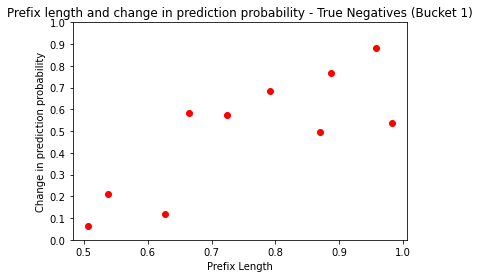

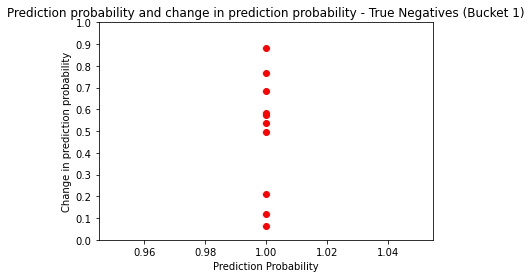

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

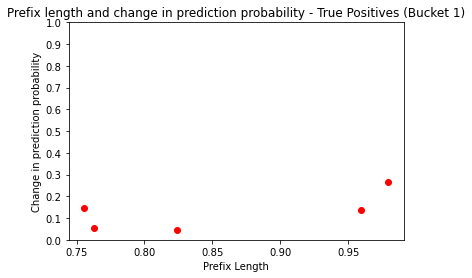

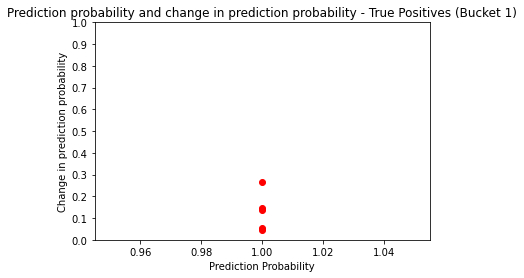

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

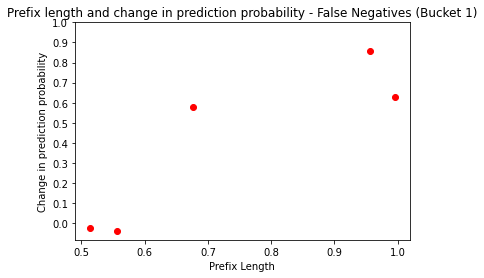

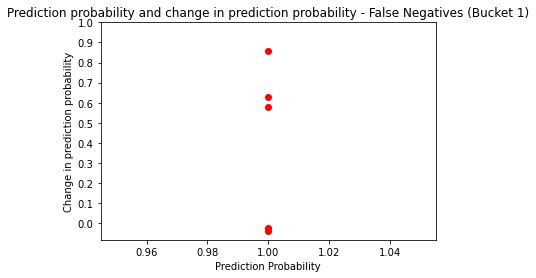

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

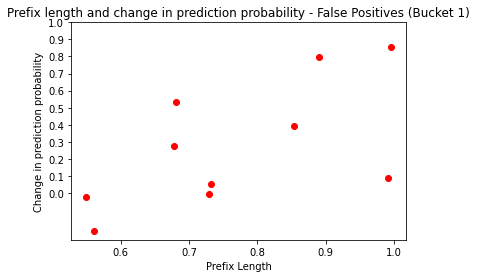

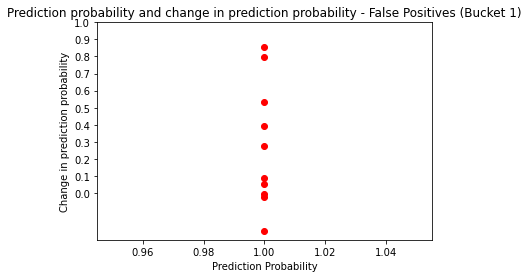

Bucket 2
Generating distributions for bucket
1 of 191 features
2 of 191 features
3 of 191 features
4 of 191 features
5 of 191 features
6 of 191 features
7 of 191 features
8 of 191 features
9 of 191 features
10 of 191 features
11 of 191 features
12 of 191 features
13 of 191 features
14 of 191 features
15 of 191 features
16 of 191 features
17 of 191 features
18 of 191 features
19 of 191 features
20 of 191 features
21 of 191 features
22 of 191 features
23 of 191 features
24 of 191 features
25 of 191 features
26 of 191 features
27 of 191 features
28 of 191 features
29 of 191 features
30 of 191 features
31 of 191 features
32 of 191 features
33 of 191 features
34 of 191 features
35 of 191 features
36 of 191 features
37 of 191 features
38 of 191 features
39 of 191 features
40 of 191 features
41 of 191 features
42 of 191 features
43 of 191 features
44 of 191 features
45 of 191 features
46 of 191 features
47 of 191 features
48 of 191 features
49 of 191 features
50 of 191 features
51 of 191 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

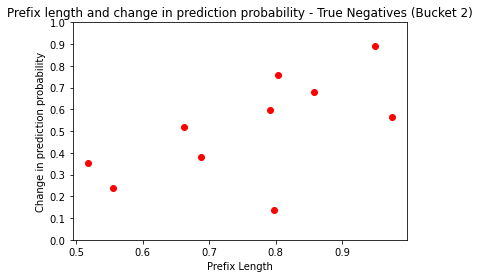

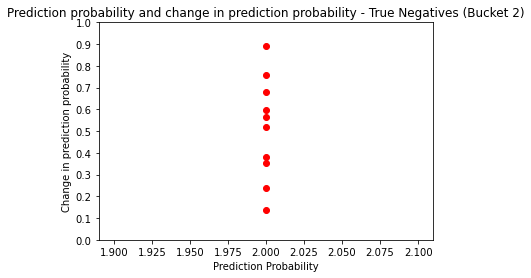

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

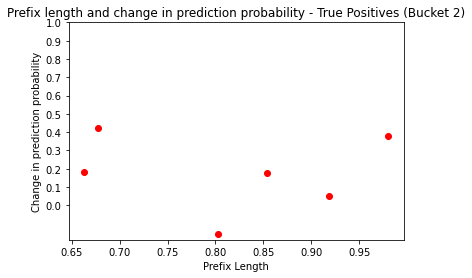

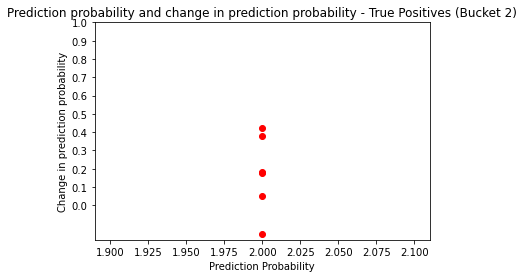

Category 3 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

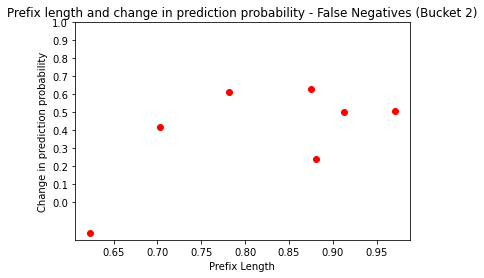

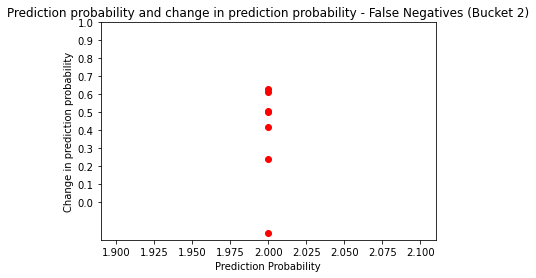

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

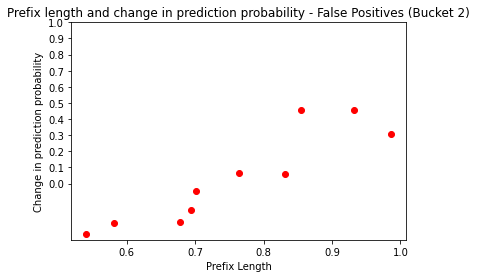

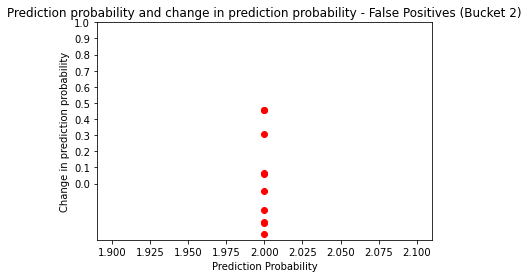

Bucket 3
Generating distributions for bucket
1 of 197 features
2 of 197 features
3 of 197 features
4 of 197 features
5 of 197 features
6 of 197 features
7 of 197 features
8 of 197 features
9 of 197 features
10 of 197 features
11 of 197 features
12 of 197 features
13 of 197 features
14 of 197 features
15 of 197 features
16 of 197 features
17 of 197 features
18 of 197 features
19 of 197 features
20 of 197 features
21 of 197 features
22 of 197 features
23 of 197 features
24 of 197 features
25 of 197 features
26 of 197 features
27 of 197 features
28 of 197 features
29 of 197 features
30 of 197 features
31 of 197 features
32 of 197 features
33 of 197 features
34 of 197 features
35 of 197 features
36 of 197 features
37 of 197 features
38 of 197 features
39 of 197 features
40 of 197 features
41 of 197 features
42 of 197 features
43 of 197 features
44 of 197 features
45 of 197 features
46 of 197 features
47 of 197 features
48 of 197 features
49 of 197 features
50 of 197 features
51 of 197 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

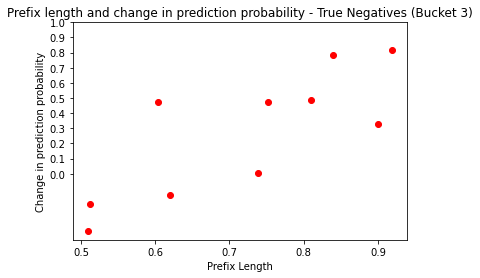

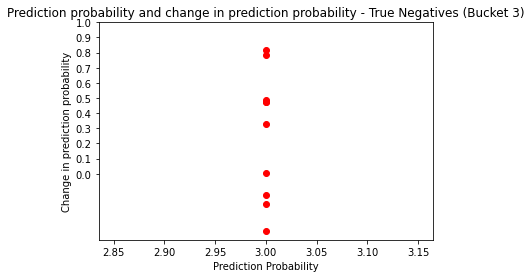

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

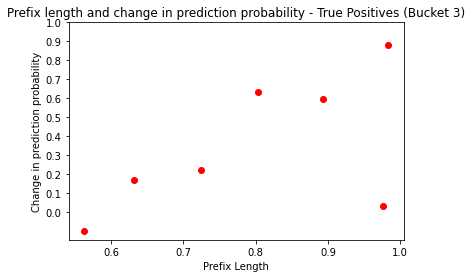

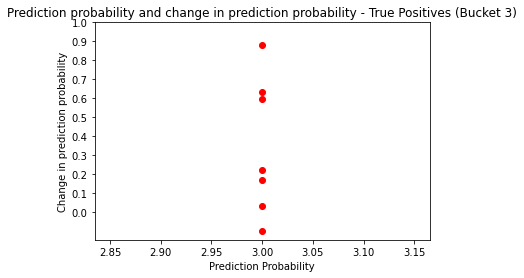

Category 3 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

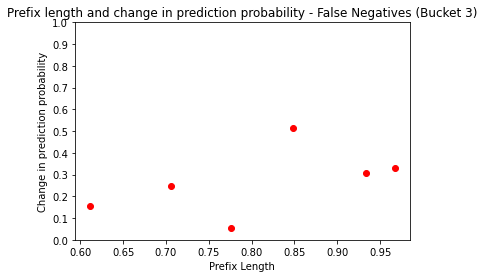

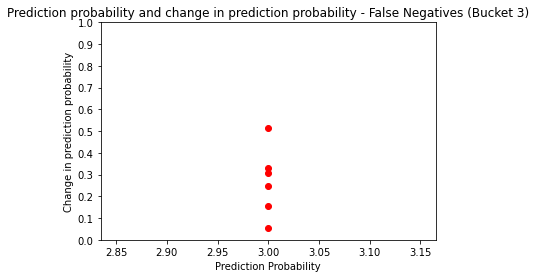

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

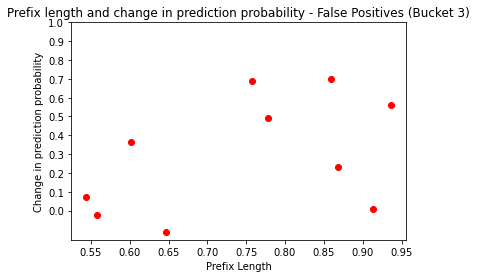

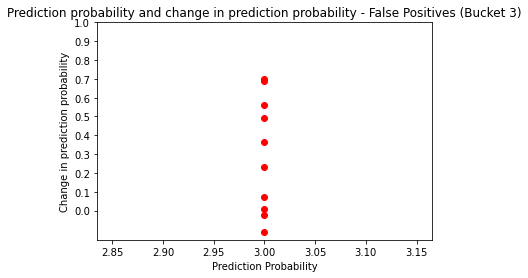

Bucket 4
Generating distributions for bucket
1 of 190 features
2 of 190 features
3 of 190 features
4 of 190 features
5 of 190 features
6 of 190 features
7 of 190 features
8 of 190 features
9 of 190 features
10 of 190 features
11 of 190 features
12 of 190 features
13 of 190 features
14 of 190 features
15 of 190 features
16 of 190 features
17 of 190 features
18 of 190 features
19 of 190 features
20 of 190 features
21 of 190 features
22 of 190 features
23 of 190 features
24 of 190 features
25 of 190 features
26 of 190 features
27 of 190 features
28 of 190 features
29 of 190 features
30 of 190 features
31 of 190 features
32 of 190 features
33 of 190 features
34 of 190 features
35 of 190 features
36 of 190 features
37 of 190 features
38 of 190 features
39 of 190 features
40 of 190 features
41 of 190 features
42 of 190 features
43 of 190 features
44 of 190 features
45 of 190 features
46 of 190 features
47 of 190 features
48 of 190 features
49 of 190 features
50 of 190 features
51 of 190 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

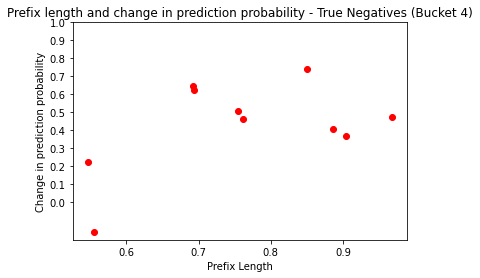

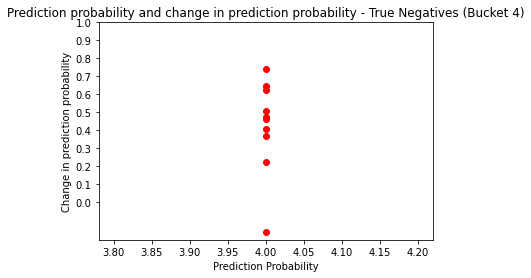

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

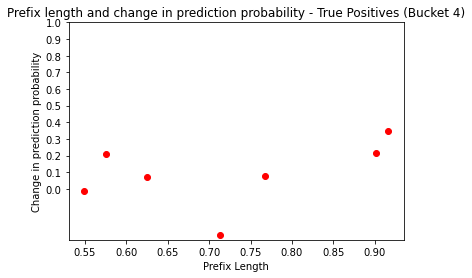

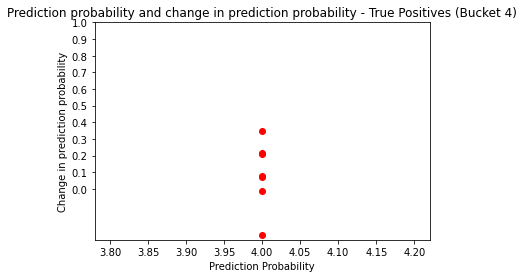

Category 3 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

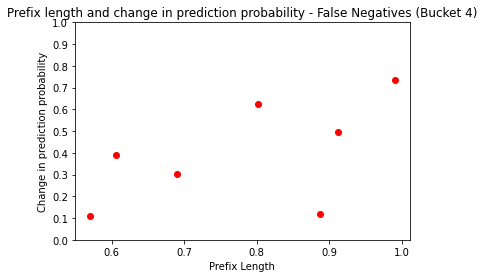

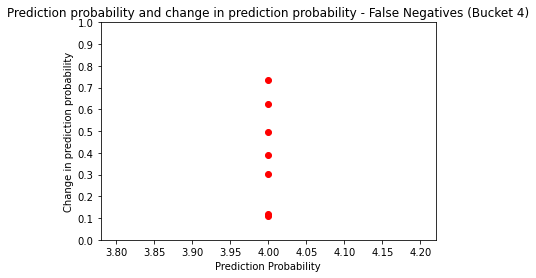

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 

Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9


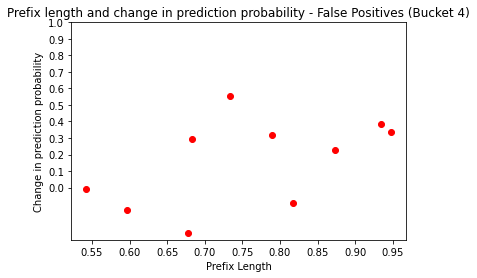

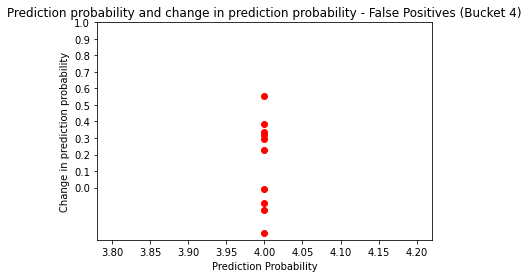

Bucket 5
Generating distributions for bucket
1 of 195 features
2 of 195 features
3 of 195 features
4 of 195 features
5 of 195 features
6 of 195 features
7 of 195 features
8 of 195 features
9 of 195 features
10 of 195 features
11 of 195 features
12 of 195 features
13 of 195 features
14 of 195 features
15 of 195 features
16 of 195 features
17 of 195 features
18 of 195 features
19 of 195 features
20 of 195 features
21 of 195 features
22 of 195 features
23 of 195 features
24 of 195 features
25 of 195 features
26 of 195 features
27 of 195 features
28 of 195 features
29 of 195 features
30 of 195 features
31 of 195 features
32 of 195 features
33 of 195 features
34 of 195 features
35 of 195 features
36 of 195 features
37 of 195 features
38 of 195 features
39 of 195 features
40 of 195 features
41 of 195 features
42 of 195 features
43 of 195 features
44 of 195 features
45 of 195 features
46 of 195 features
47 of 195 features
48 of 195 features
49 of 195 features
50 of 195 features
51 of 195 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

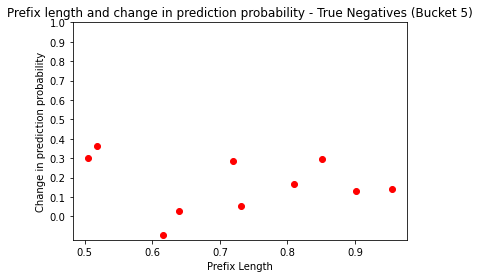

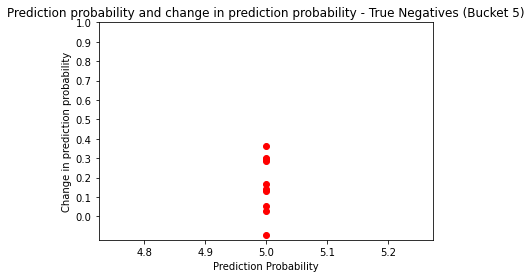

Category 2 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

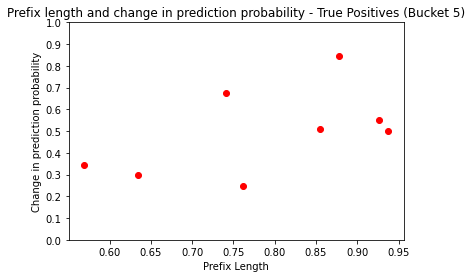

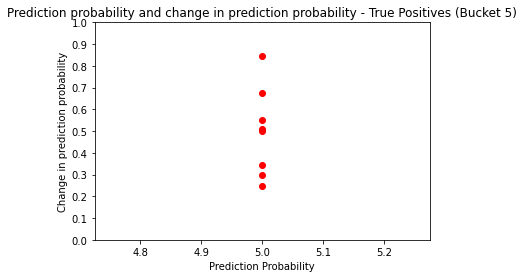

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

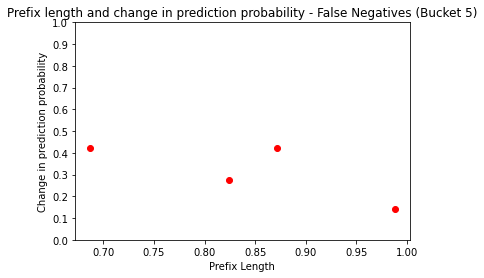

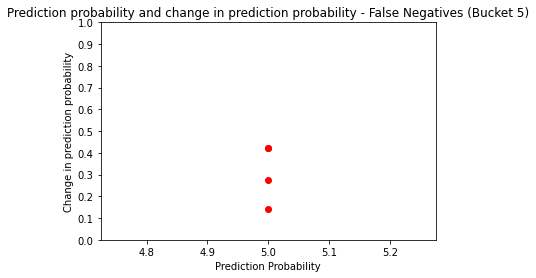

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

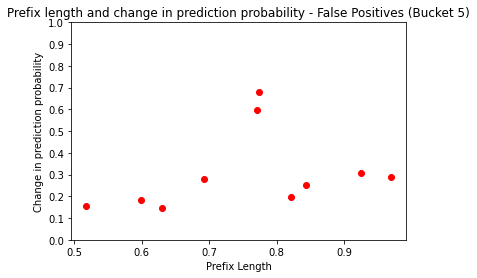

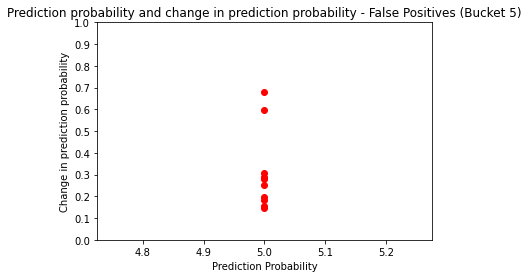

Bucket 6
Generating distributions for bucket
1 of 199 features
2 of 199 features
3 of 199 features
4 of 199 features
5 of 199 features
6 of 199 features
7 of 199 features
8 of 199 features
9 of 199 features
10 of 199 features
11 of 199 features
12 of 199 features
13 of 199 features
14 of 199 features
15 of 199 features
16 of 199 features
17 of 199 features
18 of 199 features
19 of 199 features
20 of 199 features
21 of 199 features
22 of 199 features
23 of 199 features
24 of 199 features
25 of 199 features
26 of 199 features
27 of 199 features
28 of 199 features
29 of 199 features
30 of 199 features
31 of 199 features
32 of 199 features
33 of 199 features
34 of 199 features
35 of 199 features
36 of 199 features
37 of 199 features
38 of 199 features
39 of 199 features
40 of 199 features
41 of 199 features
42 of 199 features
43 of 199 features
44 of 199 features
45 of 199 features
46 of 199 features
47 of 199 features
48 of 199 features
49 of 199 features
50 of 199 features
51 of 199 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

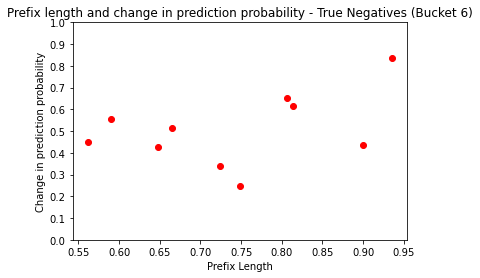

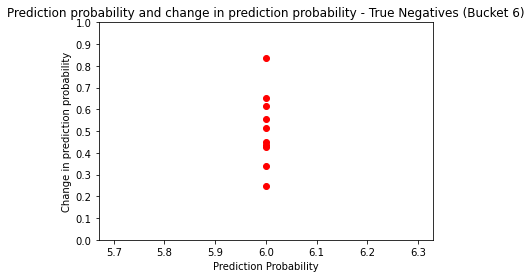

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

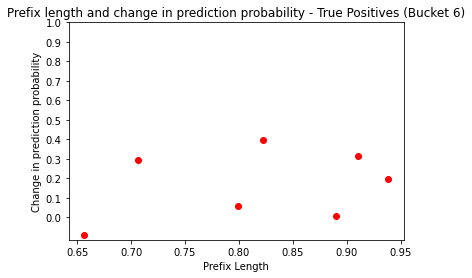

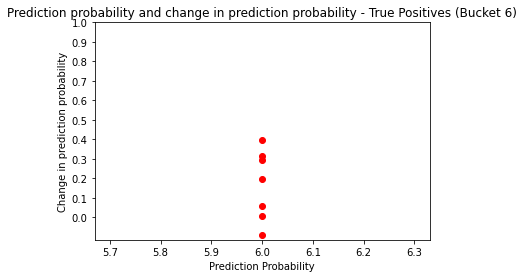

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

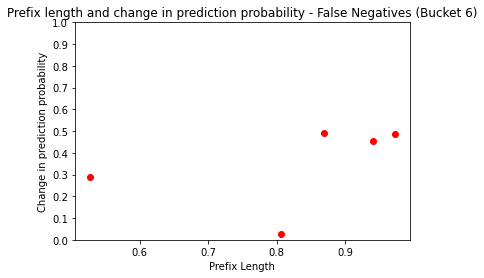

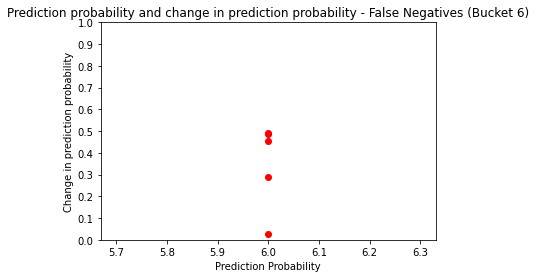

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

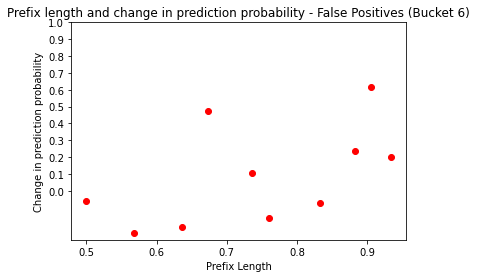

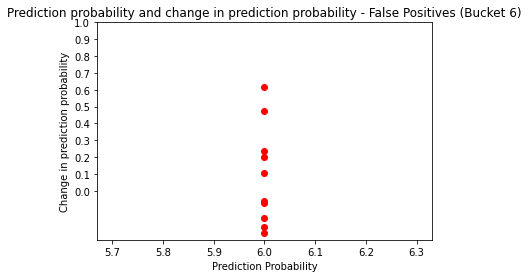

Bucket 7
Generating distributions for bucket
1 of 207 features
2 of 207 features
3 of 207 features
4 of 207 features
5 of 207 features
6 of 207 features
7 of 207 features
8 of 207 features
9 of 207 features
10 of 207 features
11 of 207 features
12 of 207 features
13 of 207 features
14 of 207 features
15 of 207 features
16 of 207 features
17 of 207 features
18 of 207 features
19 of 207 features
20 of 207 features
21 of 207 features
22 of 207 features
23 of 207 features
24 of 207 features
25 of 207 features
26 of 207 features
27 of 207 features
28 of 207 features
29 of 207 features
30 of 207 features
31 of 207 features
32 of 207 features
33 of 207 features
34 of 207 features
35 of 207 features
36 of 207 features
37 of 207 features
38 of 207 features
39 of 207 features
40 of 207 features
41 of 207 features
42 of 207 features
43 of 207 features
44 of 207 features
45 of 207 features
46 of 207 features
47 of 207 features
48 of 207 features
49 of 207 features
50 of 207 features
51 of 207 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


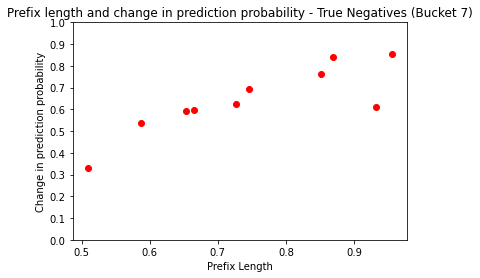

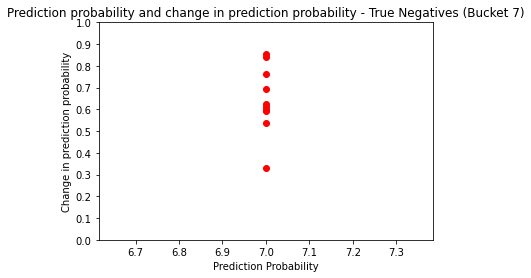

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

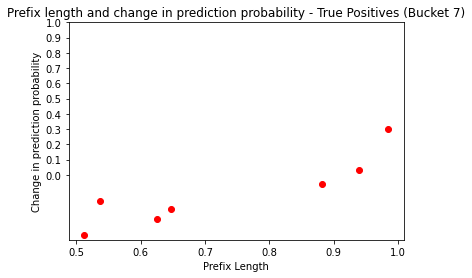

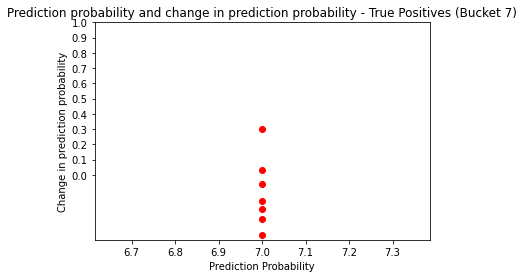

Category 3 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

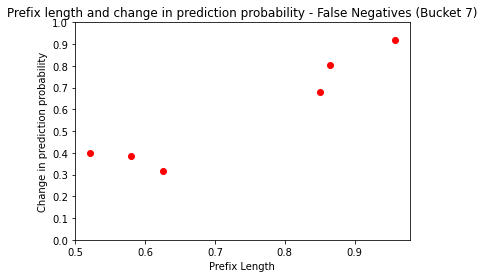

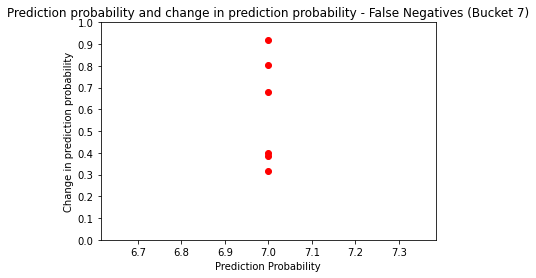

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


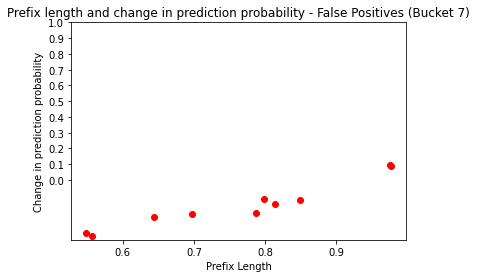

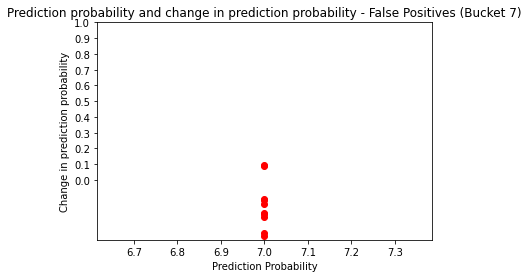

Bucket 8
Generating distributions for bucket
1 of 218 features
2 of 218 features
3 of 218 features
4 of 218 features
5 of 218 features
6 of 218 features
7 of 218 features
8 of 218 features
9 of 218 features
10 of 218 features
11 of 218 features
12 of 218 features
13 of 218 features
14 of 218 features
15 of 218 features
16 of 218 features
17 of 218 features
18 of 218 features
19 of 218 features
20 of 218 features
21 of 218 features
22 of 218 features
23 of 218 features
24 of 218 features
25 of 218 features
26 of 218 features
27 of 218 features
28 of 218 features
29 of 218 features
30 of 218 features
31 of 218 features
32 of 218 features
33 of 218 features
34 of 218 features
35 of 218 features
36 of 218 features
37 of 218 features
38 of 218 features
39 of 218 features
40 of 218 features
41 of 218 features
42 of 218 features
43 of 218 features
44 of 218 features
45 of 218 features
46 of 218 features
47 of 218 features
48 of 218 features
49 of 218 features
50 of 218 features
51 of 218 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 22
Creating distribution for feature 2 of 22
Creating distribution for feature 3 of 22
Creating distribution for feature 4 of 22
Creating distribution for feature 5 of 22
Creating distribution for feature 6 of 22
Creating distribution for feature 7 of 22
Creating distribution for feature 8 of 22
Creating distribution for feature 9 of 22
Creating distribution for feature 10 of 22
Creating distribution for feature 11 of 22
Creating distribution for feature 12 of 22
Creating distribution for feature 13 of 22
Creating distribution for feature 14 of 22
Creating distribution for feature 15 of 22
Creating distribution for feature 16 of 22
Creating distribution for feature 17 of 22
Creating distribution for feature 18 of 22
Creating distribution for feature 19 of 22
Creating distribution for feature 20 of 22
Creating distribution for feature 21 of 22
Creating distribution for feature 22 of 22
Pertubing -

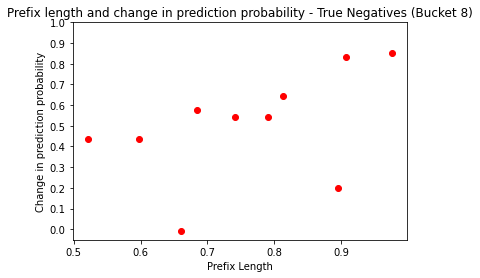

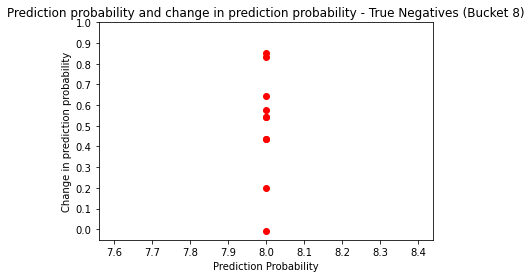

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 22
Creating distribution for feature 2 of 22
Creating distribution for feature 3 of 22
Creating distribution for feature 4 of 22
Creating distribution for feature 5 of 22
Creating distribution for feature 6 of 22
Creating distribution for feature 7 of 22
Creating distribution for feature 8 of 22
Creating distribution for feature 9 of 22
Creating distribution for feature 10 of 22
Creating distribution for feature 11 of 22
Creating distribution for feature 12 of 22
Creating distribution for feature 13 of 22
Creating distribution for feature 14 of 22
Creating distribution for feature 15 of 22
Creating distribution for feature 16 of 22
Creating distribution for feature 17 of 22
Creating distribution for feature 18 of 22
Creating distribution for feature 19 of 22
Creating distribution for feature 20 of 22
Creating distribution for feature 21 of 22
Creating distribution

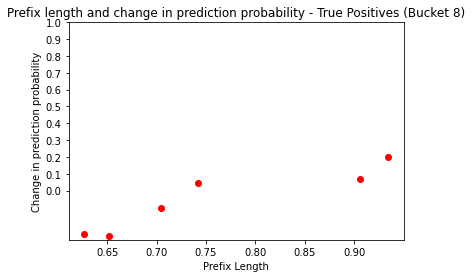

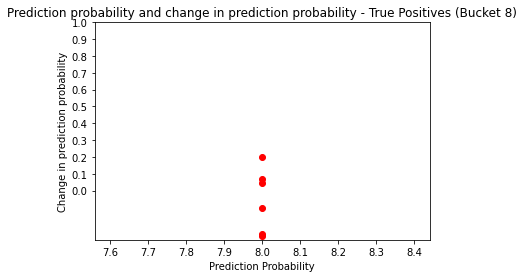

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 22
Creating distribution for feature 2 of 22
Creating distribution for feature 3 of 22
Creating distribution for feature 4 of 22
Creating distribution for feature 5 of 22
Creating distribution for feature 6 of 22
Creating distribution for feature 7 of 22
Creating distribution for feature 8 of 22
Creating distribution for feature 9 of 22
Creating distribution for feature 10 of 22
Creating distribution for feature 11 of 22
Creating distribution for feature 12 of 22
Creating distribution for feature 13 of 22
Creating distribution for feature 14 of 22
Creating distribution for feature 15 of 22
Creating distribution for feature 16 of 22
Creating distribution for feature 17 of 22
Creating distribution for feature 18 of 22
Creating distribution for feature 19 of 22
Creating distribution for feature 20 of 22
Creating distribution for feature 21 of 22
Creating distribution

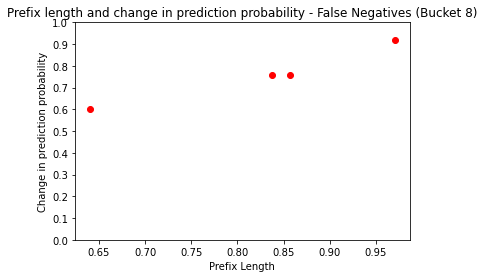

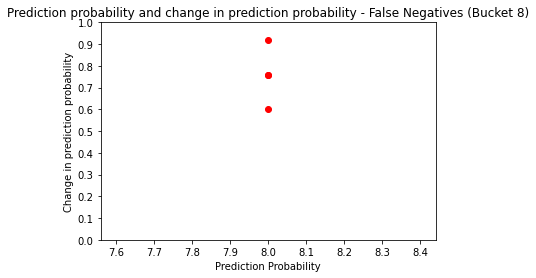

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 22
Creating distribution for feature 2 of 22
Creating distribution for feature 3 of 22
Creating distribution for feature 4 of 22
Creating distribution for feature 5 of 22
Creating distribution for feature 6 of 22
Creating distribution for feature 7 of 22
Creating distribution for feature 8 of 22
Creating distribution for feature 9 of 22
Creating distribution for feature 10 of 22
Creating distribution for feature 11 of 22
Creating distribution for feature 12 of 22
Creating distribution for feature 13 of 22
Creating distribution for feature 14 of 22
Creating distribution for feature 15 of 22
Creating distribution for feature 16 of 22
Creating distribution for feature 17 of 22
Creating distribution for feature 18 of 22
Creating distribution for feature 19 of 22
Creating distribution for feature 20 of 22
Creating distribution for feature 21 of 22
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 22
Creating distribution for feature 2 of 22
Creating distribution for feature 3 of 22
Creating distribution for feature 4 of 22
Creating distribution for feature 5 of 22
Creating distribution for feature 6 of 22
Creating distribution for feature 7 of 22
Creating distribution for feature 8 of 22
Creating distribution for feature 9 of 22
Creating distribution for feature 10 of 22
Creating distribution for feature 11 of 22
Creating distribution for feature 12 of 22
Creating distribution for feature 13 of 22
Creating distribution for feature 14 of 22
Creating distribution for feature 15 of 22
Creating distribution for feature 16 of 22
Creating distribution for feature 17 of 22
Creating distribution for feature 18 of 22
Creating distribution for feature 19 of 22
Creating distribution for feature 20 of 22
Creating distribution for feature 21 of 22
Creating distribution for feature 22 of 22
Pertubing -

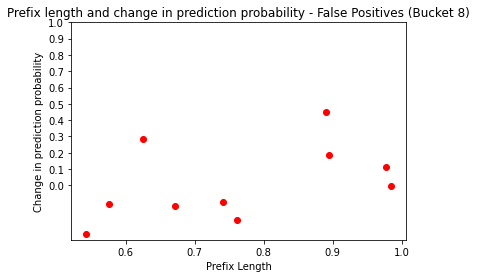

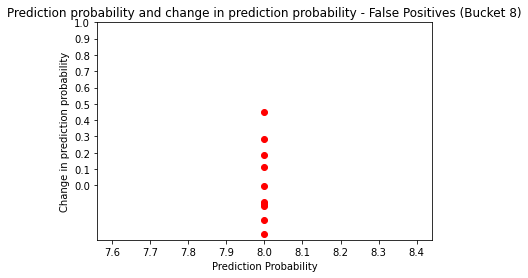

Bucket 9
Generating distributions for bucket
1 of 214 features
2 of 214 features
3 of 214 features
4 of 214 features
5 of 214 features
6 of 214 features
7 of 214 features
8 of 214 features
9 of 214 features
10 of 214 features
11 of 214 features
12 of 214 features
13 of 214 features
14 of 214 features
15 of 214 features
16 of 214 features
17 of 214 features
18 of 214 features
19 of 214 features
20 of 214 features
21 of 214 features
22 of 214 features
23 of 214 features
24 of 214 features
25 of 214 features
26 of 214 features
27 of 214 features
28 of 214 features
29 of 214 features
30 of 214 features
31 of 214 features
32 of 214 features
33 of 214 features
34 of 214 features
35 of 214 features
36 of 214 features
37 of 214 features
38 of 214 features
39 of 214 features
40 of 214 features
41 of 214 features
42 of 214 features
43 of 214 features
44 of 214 features
45 of 214 features
46 of 214 features
47 of 214 features
48 of 214 features
49 of 214 features
50 of 214 features
51 of 214 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


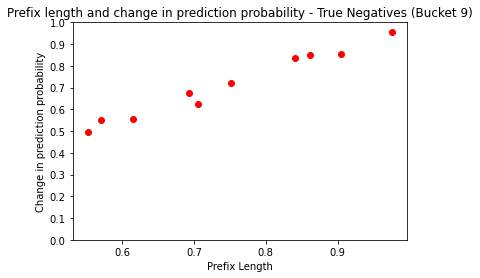

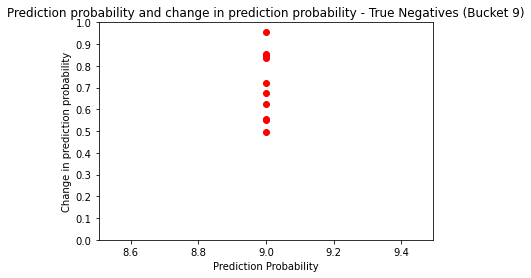

Category 2 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


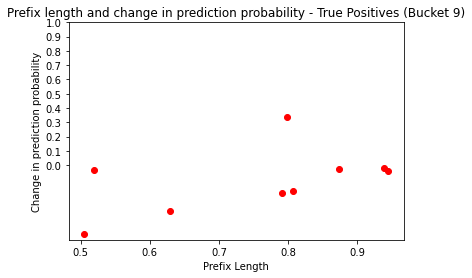

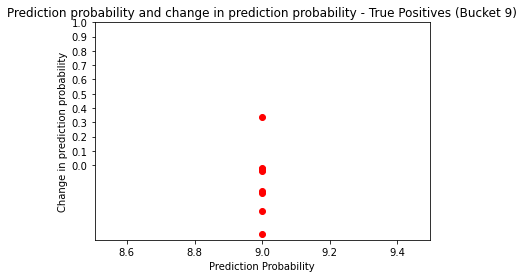

Category 3 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

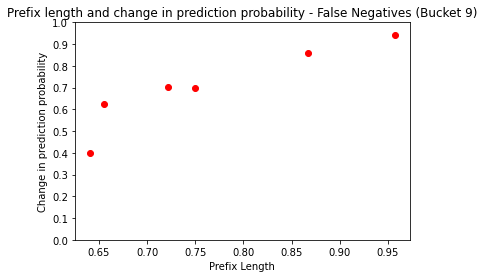

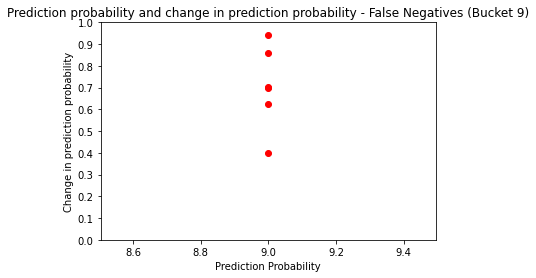

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


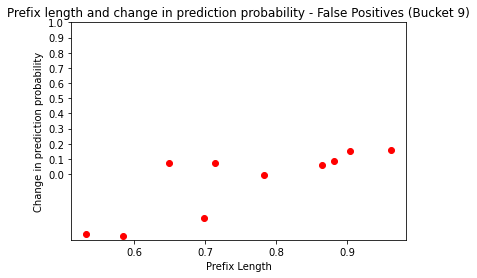

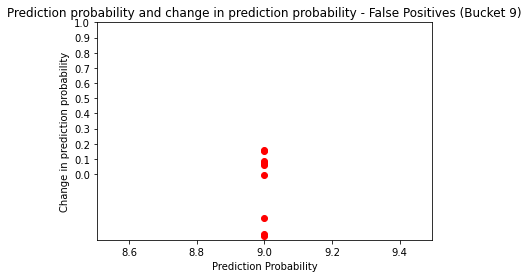

Bucket 10
Generating distributions for bucket
1 of 212 features
2 of 212 features
3 of 212 features
4 of 212 features
5 of 212 features
6 of 212 features
7 of 212 features
8 of 212 features
9 of 212 features
10 of 212 features
11 of 212 features
12 of 212 features
13 of 212 features
14 of 212 features
15 of 212 features
16 of 212 features
17 of 212 features
18 of 212 features
19 of 212 features
20 of 212 features
21 of 212 features
22 of 212 features
23 of 212 features
24 of 212 features
25 of 212 features
26 of 212 features
27 of 212 features
28 of 212 features
29 of 212 features
30 of 212 features
31 of 212 features
32 of 212 features
33 of 212 features
34 of 212 features
35 of 212 features
36 of 212 features
37 of 212 features
38 of 212 features
39 of 212 features
40 of 212 features
41 of 212 features
42 of 212 features
43 of 212 features
44 of 212 features
45 of 212 features
46 of 212 features
47 of 212 features
48 of 212 features
49 of 212 features
50 of 212 features
51 of 212 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


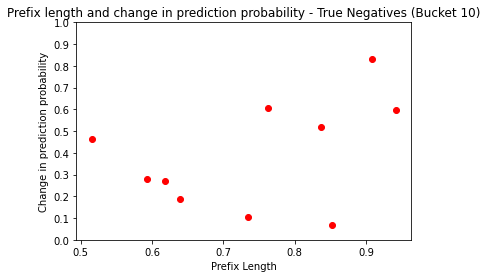

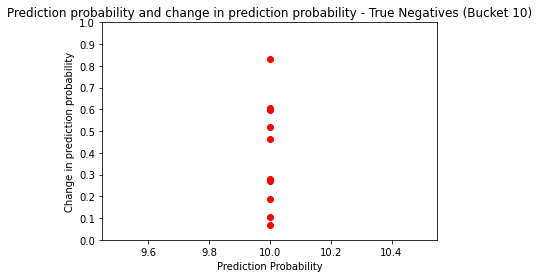

Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

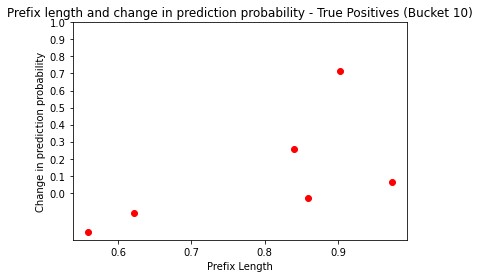

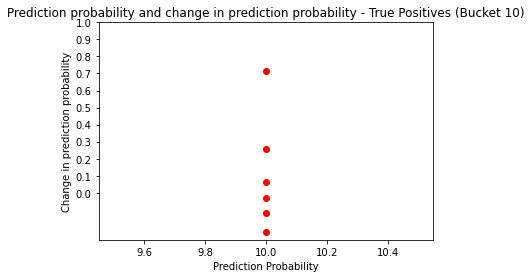

Category 3 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


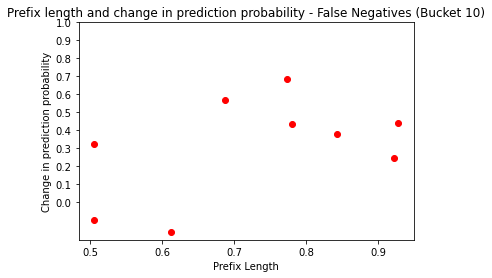

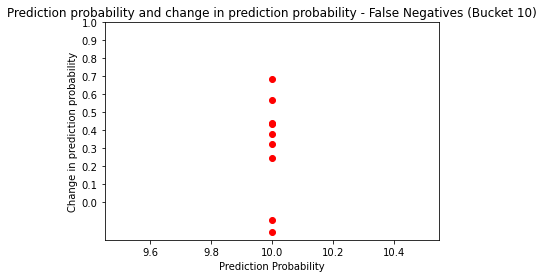

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


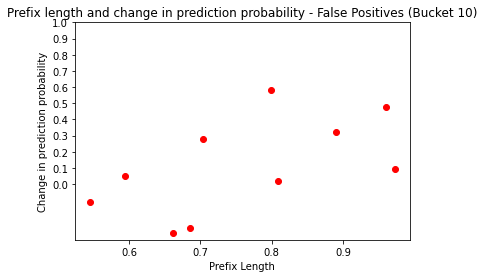

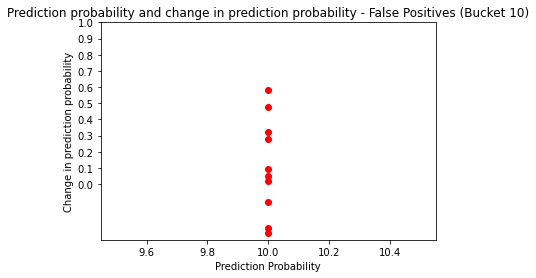

Bucket 11
Generating distributions for bucket
1 of 213 features
2 of 213 features
3 of 213 features
4 of 213 features
5 of 213 features
6 of 213 features
7 of 213 features
8 of 213 features
9 of 213 features
10 of 213 features
11 of 213 features
12 of 213 features
13 of 213 features
14 of 213 features
15 of 213 features
16 of 213 features
17 of 213 features
18 of 213 features
19 of 213 features
20 of 213 features
21 of 213 features
22 of 213 features
23 of 213 features
24 of 213 features
25 of 213 features
26 of 213 features
27 of 213 features
28 of 213 features
29 of 213 features
30 of 213 features
31 of 213 features
32 of 213 features
33 of 213 features
34 of 213 features
35 of 213 features
36 of 213 features
37 of 213 features
38 of 213 features
39 of 213 features
40 of 213 features
41 of 213 features
42 of 213 features
43 of 213 features
44 of 213 features
45 of 213 features
46 of 213 features
47 of 213 features
48 of 213 features
49 of 213 features
50 of 213 features
51 of 213 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


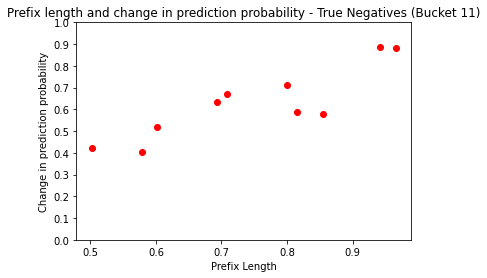

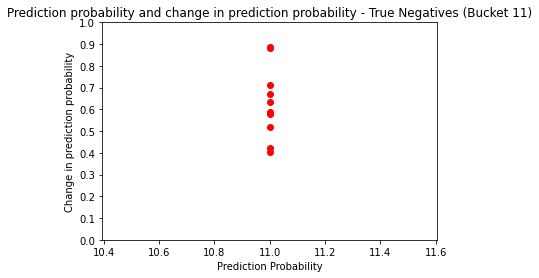

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

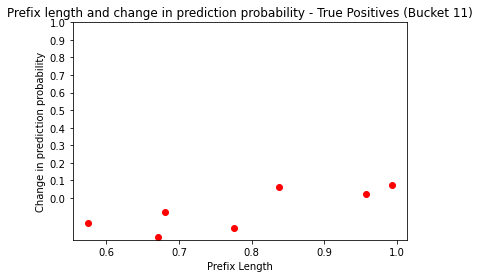

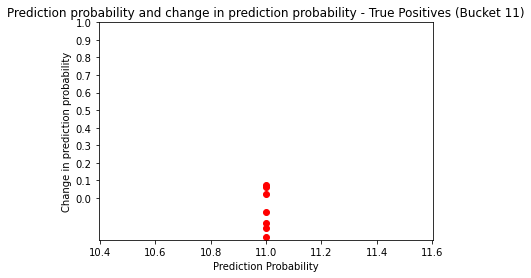

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

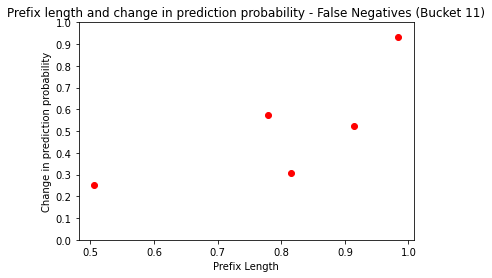

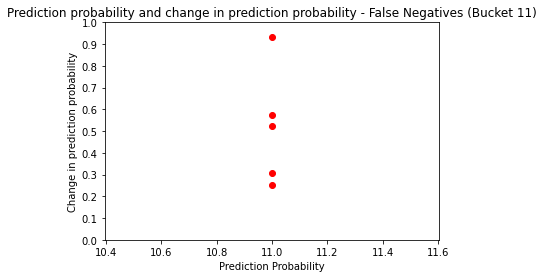

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


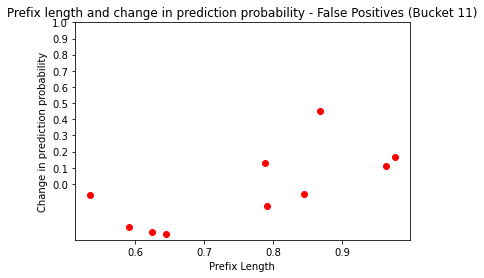

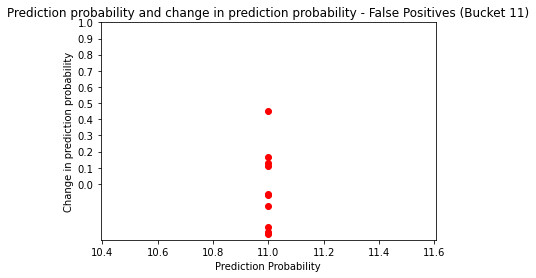

Bucket 12
Generating distributions for bucket
1 of 206 features
2 of 206 features
3 of 206 features
4 of 206 features
5 of 206 features
6 of 206 features
7 of 206 features
8 of 206 features
9 of 206 features
10 of 206 features
11 of 206 features
12 of 206 features
13 of 206 features
14 of 206 features
15 of 206 features
16 of 206 features
17 of 206 features
18 of 206 features
19 of 206 features
20 of 206 features
21 of 206 features
22 of 206 features
23 of 206 features
24 of 206 features
25 of 206 features
26 of 206 features
27 of 206 features
28 of 206 features
29 of 206 features
30 of 206 features
31 of 206 features
32 of 206 features
33 of 206 features
34 of 206 features
35 of 206 features
36 of 206 features
37 of 206 features
38 of 206 features
39 of 206 features
40 of 206 features
41 of 206 features
42 of 206 features
43 of 206 features
44 of 206 features
45 of 206 features
46 of 206 features
47 of 206 features
48 of 206 features
49 of 206 features
50 of 206 features
51 of 206 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


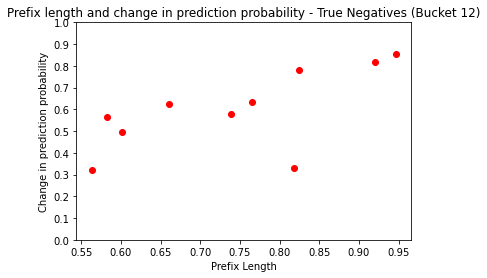

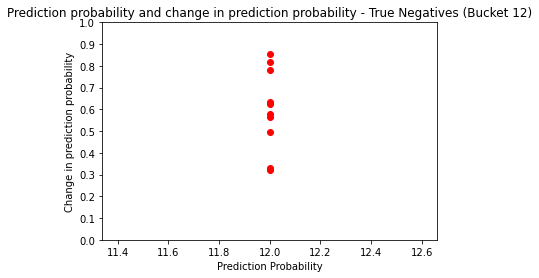

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

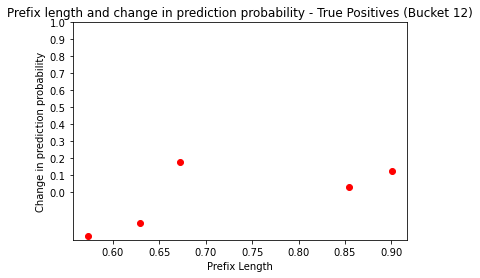

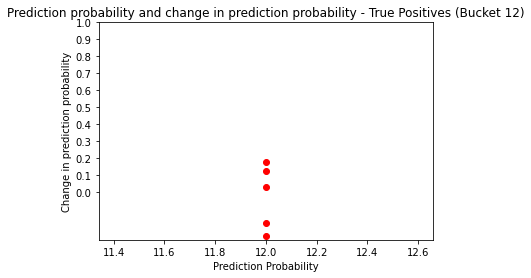

Category 3 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

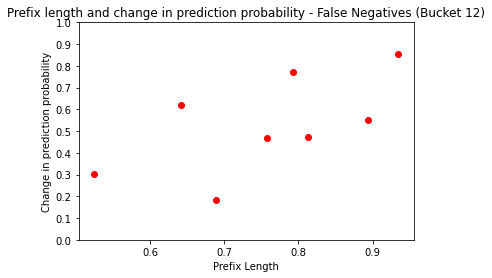

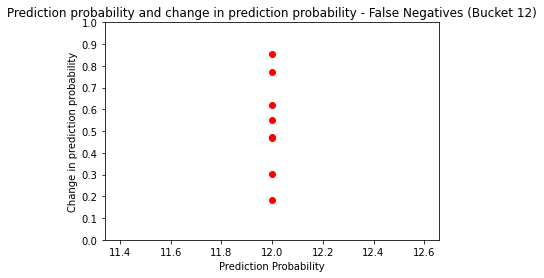

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


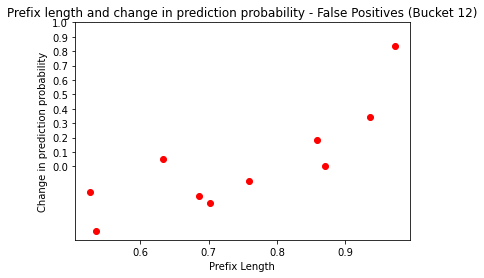

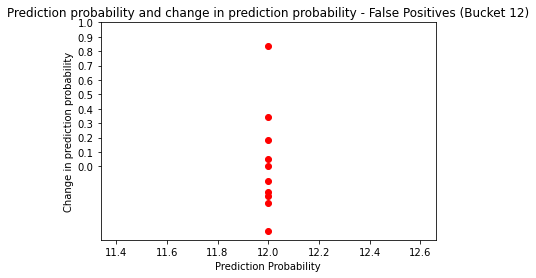

Bucket 13
Generating distributions for bucket
1 of 208 features
2 of 208 features
3 of 208 features
4 of 208 features
5 of 208 features
6 of 208 features
7 of 208 features
8 of 208 features
9 of 208 features
10 of 208 features
11 of 208 features
12 of 208 features
13 of 208 features
14 of 208 features
15 of 208 features
16 of 208 features
17 of 208 features
18 of 208 features
19 of 208 features
20 of 208 features
21 of 208 features
22 of 208 features
23 of 208 features
24 of 208 features
25 of 208 features
26 of 208 features
27 of 208 features
28 of 208 features
29 of 208 features
30 of 208 features
31 of 208 features
32 of 208 features
33 of 208 features
34 of 208 features
35 of 208 features
36 of 208 features
37 of 208 features
38 of 208 features
39 of 208 features
40 of 208 features
41 of 208 features
42 of 208 features
43 of 208 features
44 of 208 features
45 of 208 features
46 of 208 features
47 of 208 features
48 of 208 features
49 of 208 features
50 of 208 features
51 of 208 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


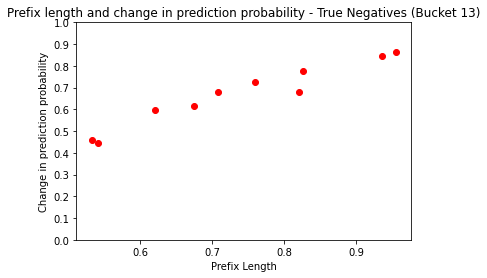

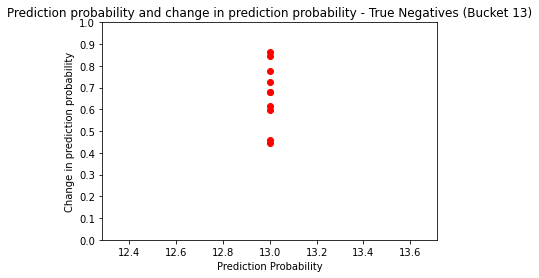

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

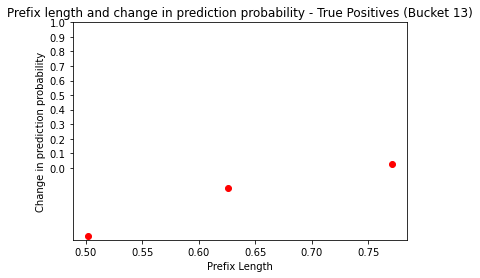

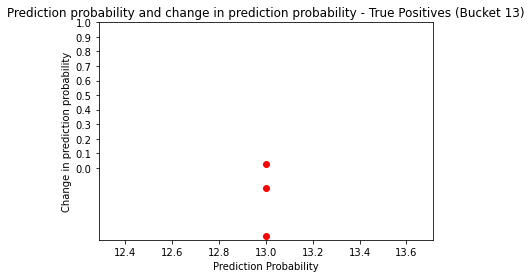

Category 3 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

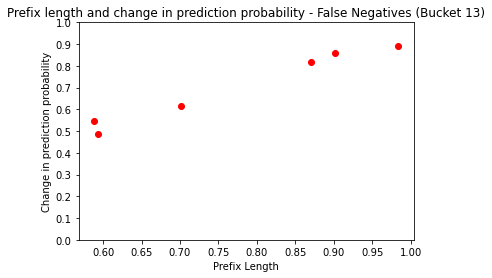

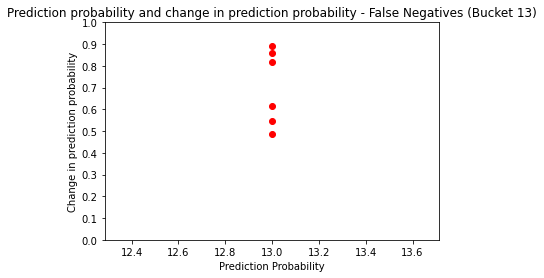

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


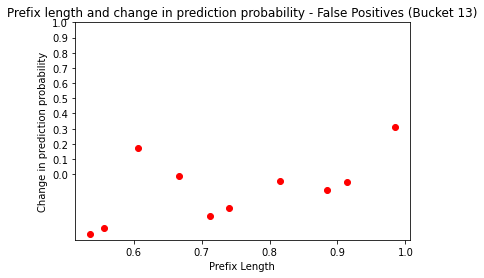

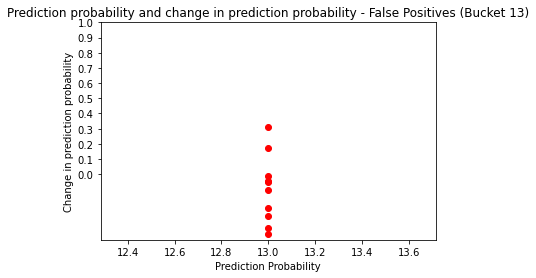

Bucket 14
Generating distributions for bucket
1 of 202 features
2 of 202 features
3 of 202 features
4 of 202 features
5 of 202 features
6 of 202 features
7 of 202 features
8 of 202 features
9 of 202 features
10 of 202 features
11 of 202 features
12 of 202 features
13 of 202 features
14 of 202 features
15 of 202 features
16 of 202 features
17 of 202 features
18 of 202 features
19 of 202 features
20 of 202 features
21 of 202 features
22 of 202 features
23 of 202 features
24 of 202 features
25 of 202 features
26 of 202 features
27 of 202 features
28 of 202 features
29 of 202 features
30 of 202 features
31 of 202 features
32 of 202 features
33 of 202 features
34 of 202 features
35 of 202 features
36 of 202 features
37 of 202 features
38 of 202 features
39 of 202 features
40 of 202 features
41 of 202 features
42 of 202 features
43 of 202 features
44 of 202 features
45 of 202 features
46 of 202 features
47 of 202 features
48 of 202 features
49 of 202 features
50 of 202 features
51 of 202 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

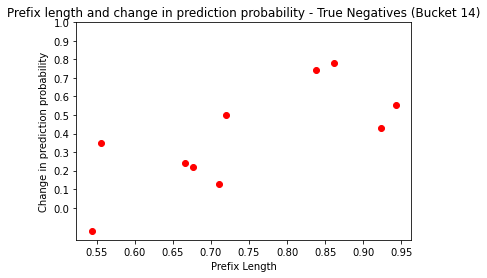

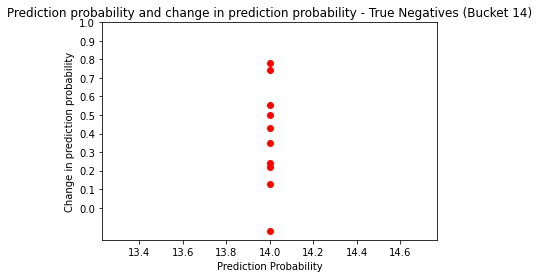

Category 2 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

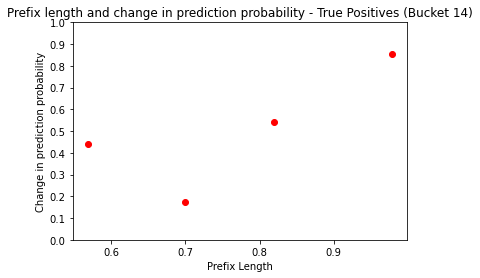

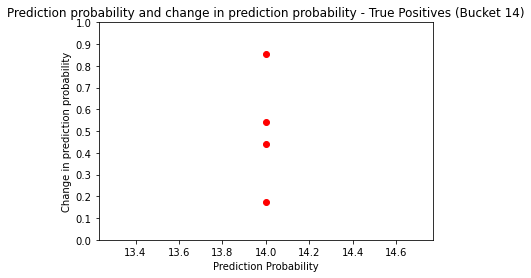

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

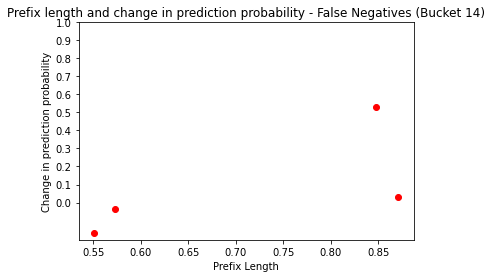

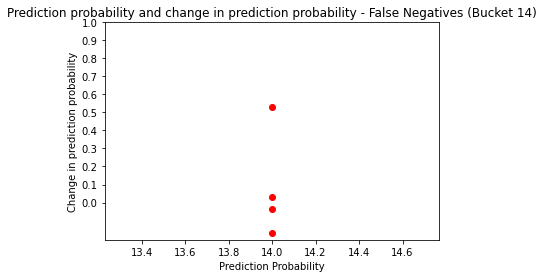

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

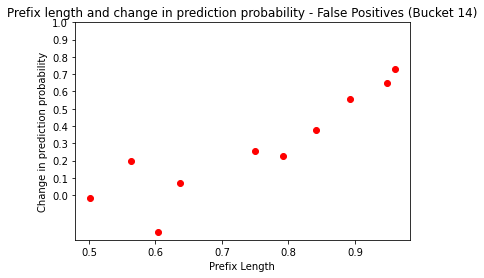

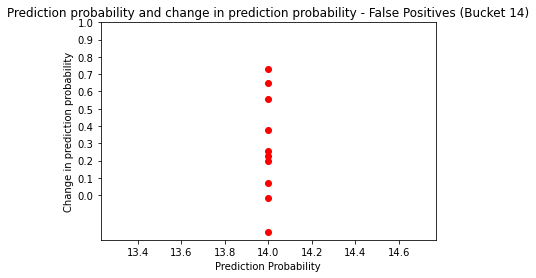

Bucket 15
Generating distributions for bucket
1 of 201 features
2 of 201 features
3 of 201 features
4 of 201 features
5 of 201 features
6 of 201 features
7 of 201 features
8 of 201 features
9 of 201 features
10 of 201 features
11 of 201 features
12 of 201 features
13 of 201 features
14 of 201 features
15 of 201 features
16 of 201 features
17 of 201 features
18 of 201 features
19 of 201 features
20 of 201 features
21 of 201 features
22 of 201 features
23 of 201 features
24 of 201 features
25 of 201 features
26 of 201 features
27 of 201 features
28 of 201 features
29 of 201 features
30 of 201 features
31 of 201 features
32 of 201 features
33 of 201 features
34 of 201 features
35 of 201 features
36 of 201 features
37 of 201 features
38 of 201 features
39 of 201 features
40 of 201 features
41 of 201 features
42 of 201 features
43 of 201 features
44 of 201 features
45 of 201 features
46 of 201 features
47 of 201 features
48 of 201 features
49 of 201 features
50 of 201 features
51 of 201 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

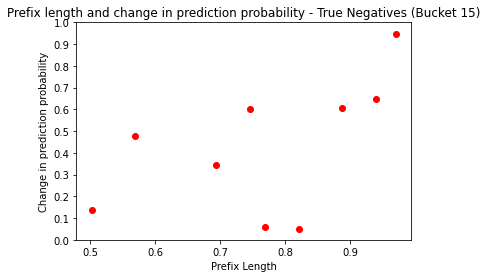

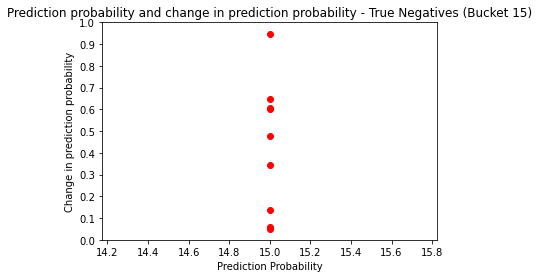

Category 2 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

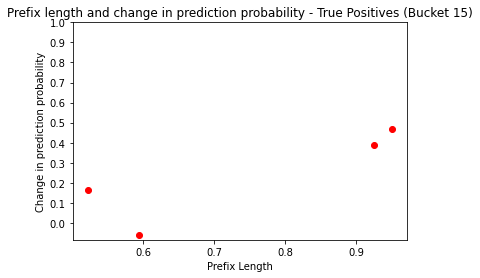

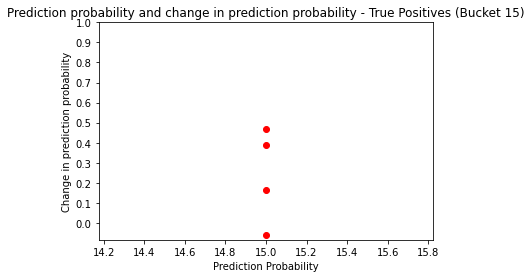

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

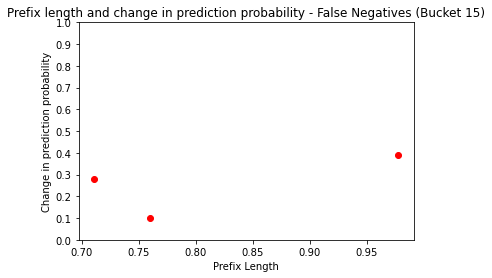

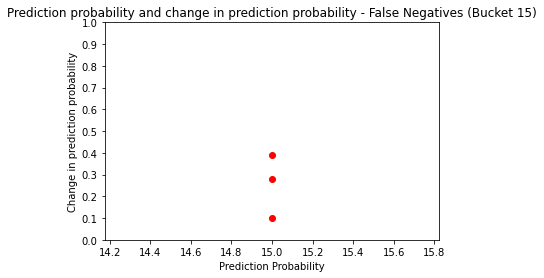

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

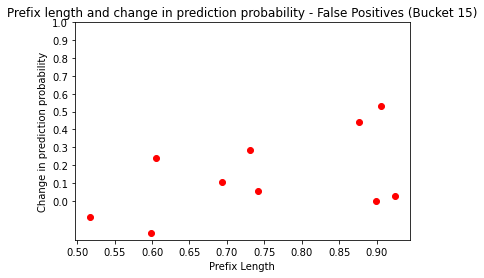

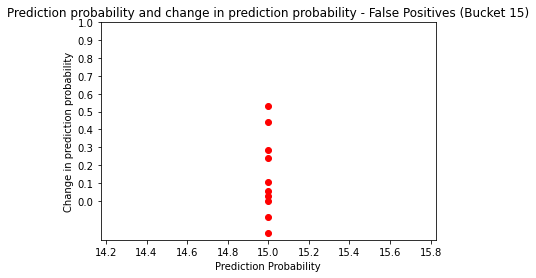

Bucket 16
Generating distributions for bucket
1 of 195 features
2 of 195 features
3 of 195 features
4 of 195 features
5 of 195 features
6 of 195 features
7 of 195 features
8 of 195 features
9 of 195 features
10 of 195 features
11 of 195 features
12 of 195 features
13 of 195 features
14 of 195 features
15 of 195 features
16 of 195 features
17 of 195 features
18 of 195 features
19 of 195 features
20 of 195 features
21 of 195 features
22 of 195 features
23 of 195 features
24 of 195 features
25 of 195 features
26 of 195 features
27 of 195 features
28 of 195 features
29 of 195 features
30 of 195 features
31 of 195 features
32 of 195 features
33 of 195 features
34 of 195 features
35 of 195 features
36 of 195 features
37 of 195 features
38 of 195 features
39 of 195 features
40 of 195 features
41 of 195 features
42 of 195 features
43 of 195 features
44 of 195 features
45 of 195 features
46 of 195 features
47 of 195 features
48 of 195 features
49 of 195 features
50 of 195 features
51 of 195 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubi

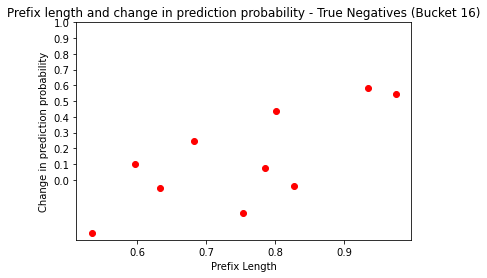

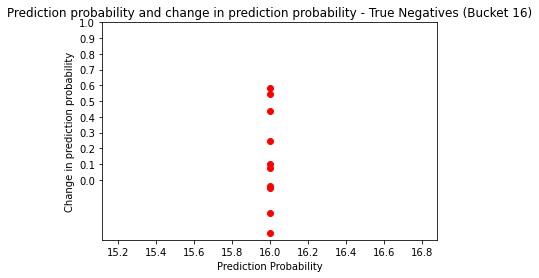

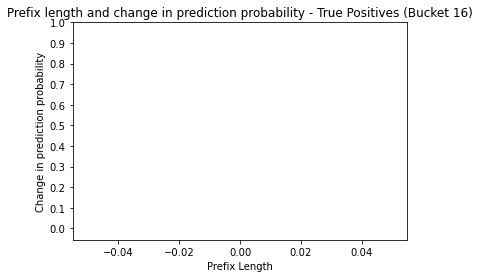

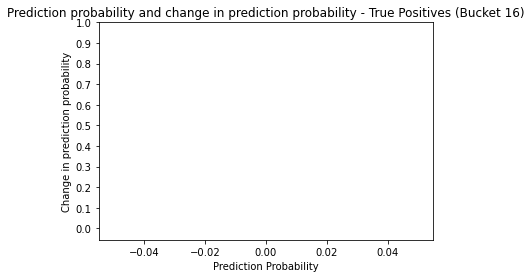

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing 

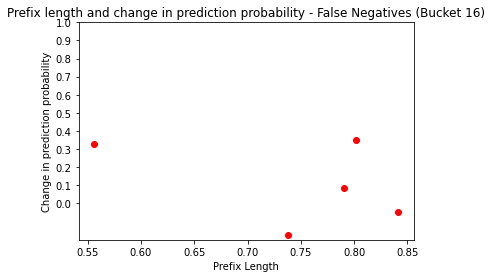

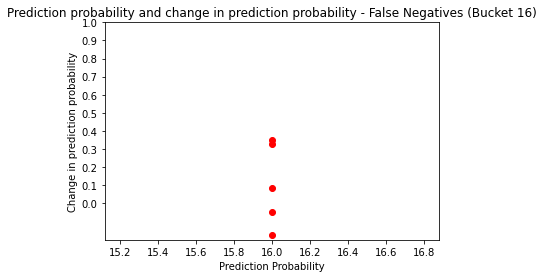

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing

Identifying relevant features
Creating distribution for feature 1 of 20
Creating distribution for feature 2 of 20
Creating distribution for feature 3 of 20
Creating distribution for feature 4 of 20
Creating distribution for feature 5 of 20
Creating distribution for feature 6 of 20
Creating distribution for feature 7 of 20
Creating distribution for feature 8 of 20
Creating distribution for feature 9 of 20
Creating distribution for feature 10 of 20
Creating distribution for feature 11 of 20
Creating distribution for feature 12 of 20
Creating distribution for feature 13 of 20
Creating distribution for feature 14 of 20
Creating distribution for feature 15 of 20
Creating distribution for feature 16 of 20
Creating distribution for feature 17 of 20
Creating distribution for feature 18 of 20
Creating distribution for feature 19 of 20
Creating distribution for feature 20 of 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing -

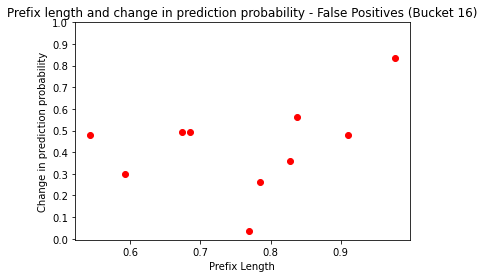

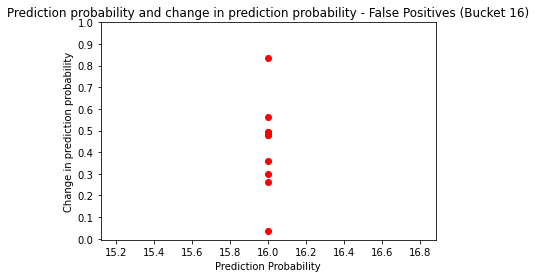

Bucket 17
Generating distributions for bucket
1 of 184 features
2 of 184 features
3 of 184 features
4 of 184 features
5 of 184 features
6 of 184 features
7 of 184 features
8 of 184 features
9 of 184 features
10 of 184 features
11 of 184 features
12 of 184 features
13 of 184 features
14 of 184 features
15 of 184 features
16 of 184 features
17 of 184 features
18 of 184 features
19 of 184 features
20 of 184 features
21 of 184 features
22 of 184 features
23 of 184 features
24 of 184 features
25 of 184 features
26 of 184 features
27 of 184 features
28 of 184 features
29 of 184 features
30 of 184 features
31 of 184 features
32 of 184 features
33 of 184 features
34 of 184 features
35 of 184 features
36 of 184 features
37 of 184 features
38 of 184 features
39 of 184 features
40 of 184 features
41 of 184 features
42 of 184 features
43 of 184 features
44 of 184 features
45 of 184 features
46 of 184 features
47 of 184 features
48 of 184 features
49 of 184 features
50 of 184 features
51 of 184 fea

Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instanc

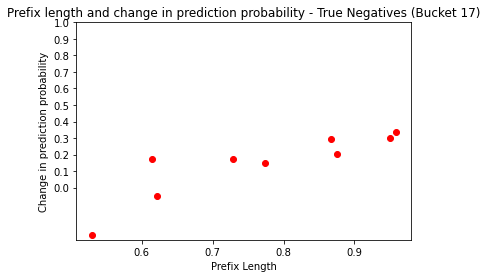

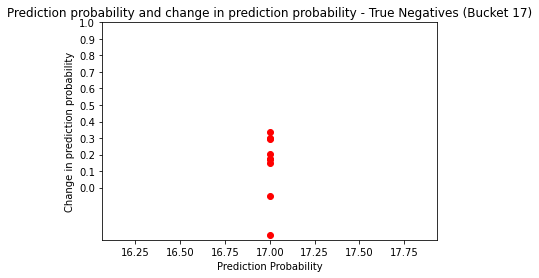

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertub

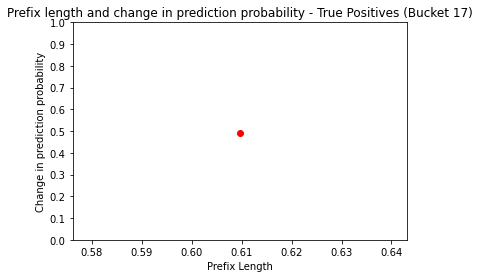

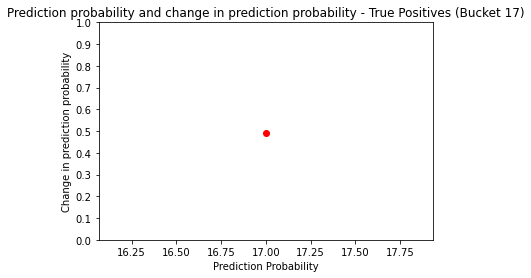

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertub

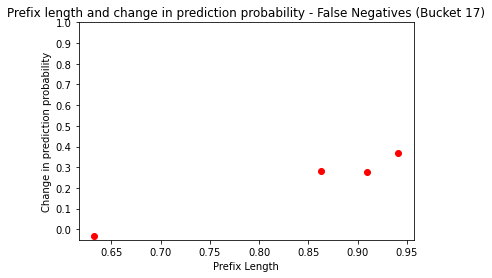

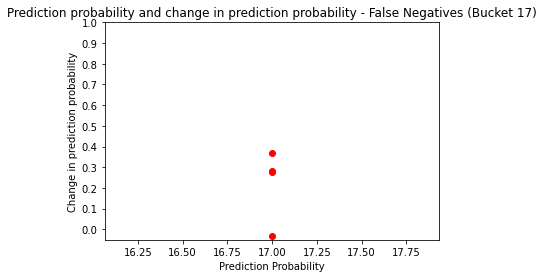

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertu

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Ca

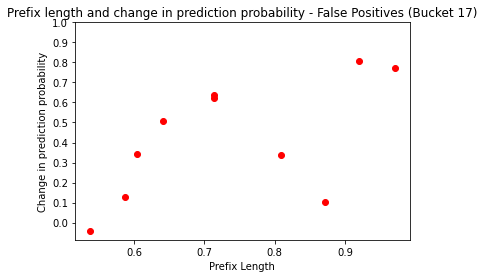

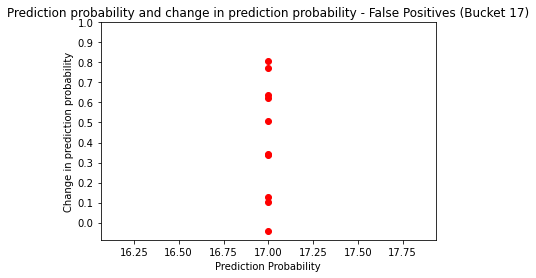

Bucket 18
Generating distributions for bucket
1 of 180 features
2 of 180 features
3 of 180 features
4 of 180 features
5 of 180 features
6 of 180 features
7 of 180 features
8 of 180 features
9 of 180 features
10 of 180 features
11 of 180 features
12 of 180 features
13 of 180 features
14 of 180 features
15 of 180 features
16 of 180 features
17 of 180 features
18 of 180 features
19 of 180 features
20 of 180 features
21 of 180 features
22 of 180 features
23 of 180 features
24 of 180 features
25 of 180 features
26 of 180 features
27 of 180 features
28 of 180 features
29 of 180 features
30 of 180 features
31 of 180 features
32 of 180 features
33 of 180 features
34 of 180 features
35 of 180 features
36 of 180 features
37 of 180 features
38 of 180 features
39 of 180 features
40 of 180 features
41 of 180 features
42 of 180 features
43 of 180 features
44 of 180 features
45 of 180 features
46 of 180 features
47 of 180 features
48 of 180 features
49 of 180 features
50 of 180 features
51 of 180 fea

Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instanc

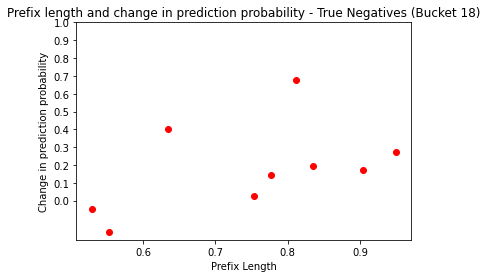

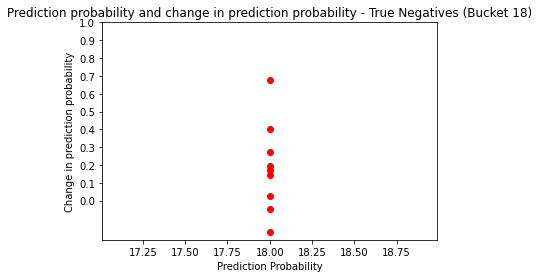

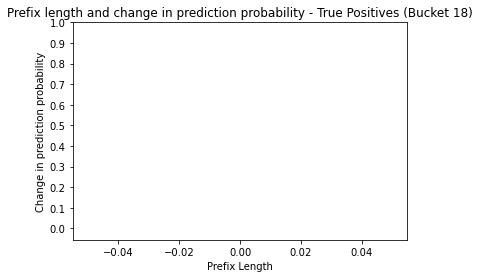

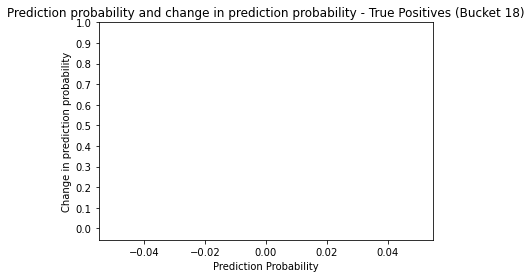

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertub

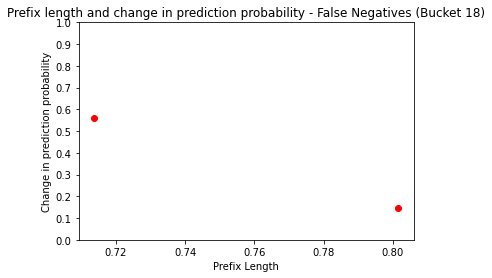

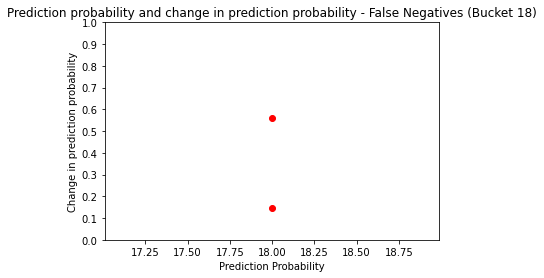

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertu

Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instanc

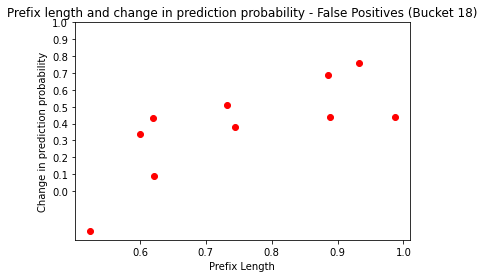

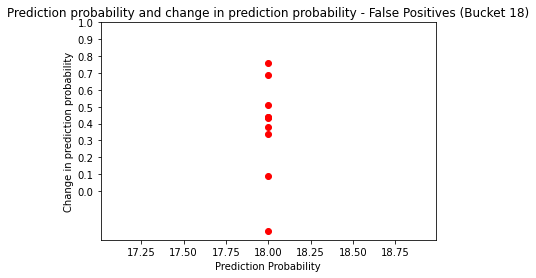

Bucket 19
Generating distributions for bucket
1 of 172 features
2 of 172 features
3 of 172 features
4 of 172 features
5 of 172 features
6 of 172 features
7 of 172 features
8 of 172 features
9 of 172 features
10 of 172 features
11 of 172 features
12 of 172 features
13 of 172 features
14 of 172 features
15 of 172 features
16 of 172 features
17 of 172 features
18 of 172 features
19 of 172 features
20 of 172 features
21 of 172 features
22 of 172 features
23 of 172 features
24 of 172 features
25 of 172 features
26 of 172 features
27 of 172 features
28 of 172 features
29 of 172 features
30 of 172 features
31 of 172 features
32 of 172 features
33 of 172 features
34 of 172 features
35 of 172 features
36 of 172 features
37 of 172 features
38 of 172 features
39 of 172 features
40 of 172 features
41 of 172 features
42 of 172 features
43 of 172 features
44 of 172 features
45 of 172 features
46 of 172 features
47 of 172 features
48 of 172 features
49 of 172 features
50 of 172 features
51 of 172 fea

Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating dis

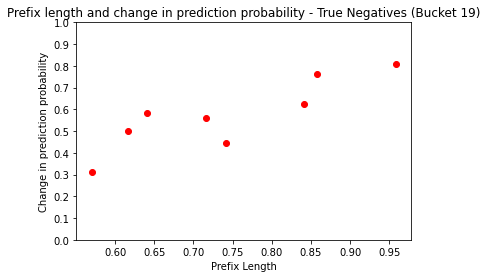

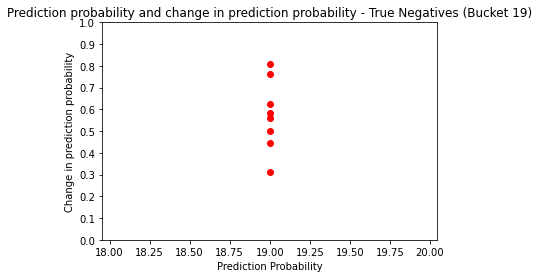

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


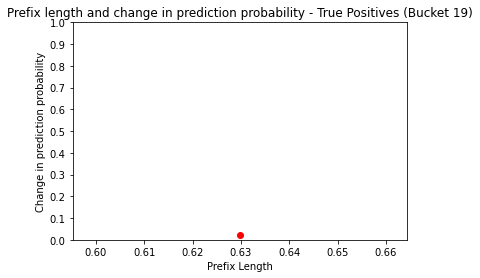

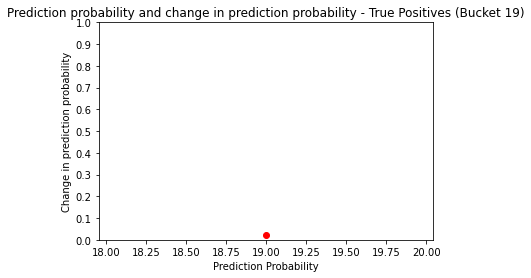

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


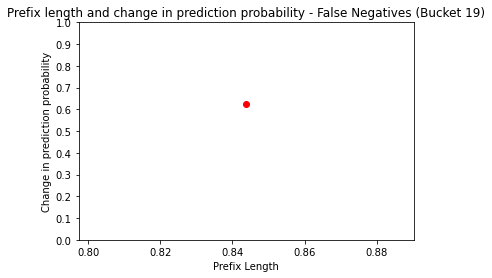

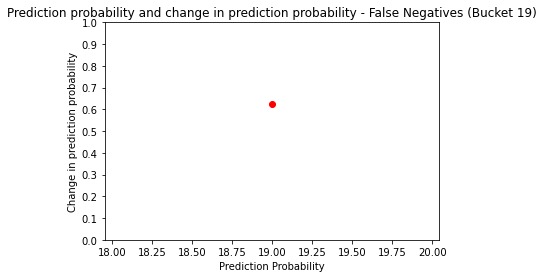

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 o

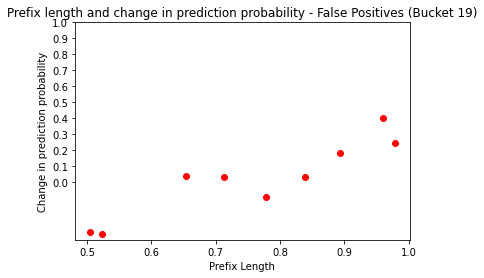

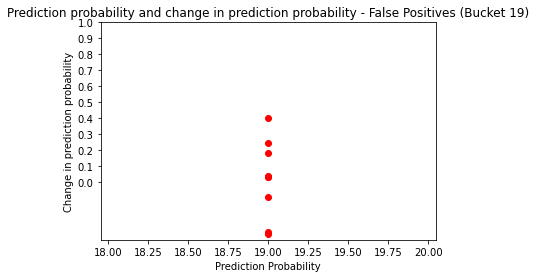

Bucket 20
Generating distributions for bucket
1 of 176 features
2 of 176 features
3 of 176 features
4 of 176 features
5 of 176 features
6 of 176 features
7 of 176 features
8 of 176 features
9 of 176 features
10 of 176 features
11 of 176 features
12 of 176 features
13 of 176 features
14 of 176 features
15 of 176 features
16 of 176 features
17 of 176 features
18 of 176 features
19 of 176 features
20 of 176 features
21 of 176 features
22 of 176 features
23 of 176 features
24 of 176 features
25 of 176 features
26 of 176 features
27 of 176 features
28 of 176 features
29 of 176 features
30 of 176 features
31 of 176 features
32 of 176 features
33 of 176 features
34 of 176 features
35 of 176 features
36 of 176 features
37 of 176 features
38 of 176 features
39 of 176 features
40 of 176 features
41 of 176 features
42 of 176 features
43 of 176 features
44 of 176 features
45 of 176 features
46 of 176 features
47 of 176 features
48 of 176 features
49 of 176 features
50 of 176 features
51 of 176 fea

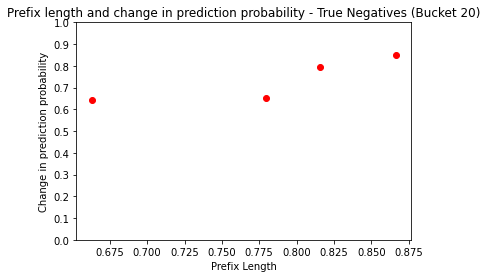

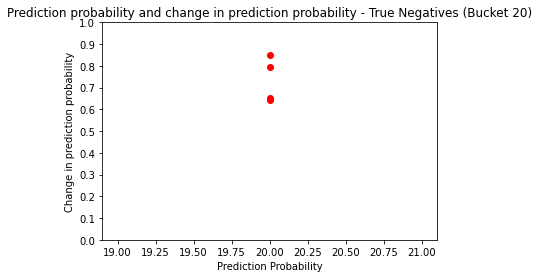

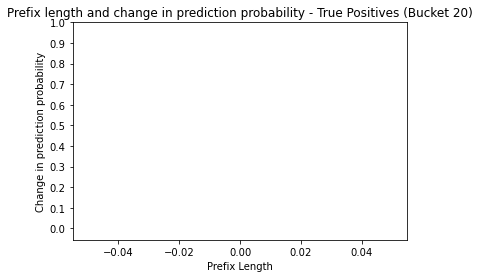

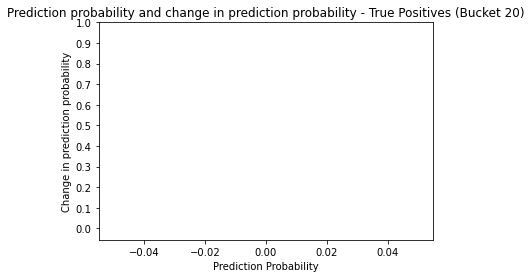

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertub

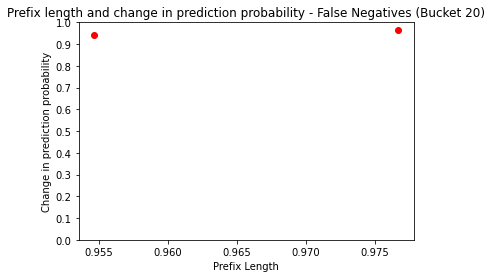

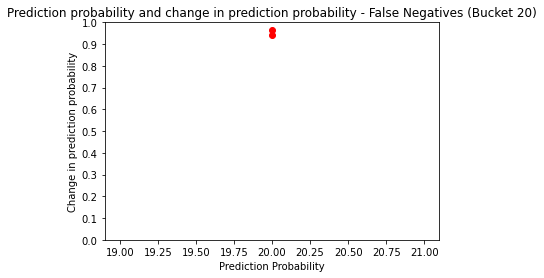

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertu

Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 18
Creating distribution for feature 2 of 18
Creating distribution for feature 3 of 18
Creating distribution for feature 4 of 18
Creating distribution for feature 5 of 18
Creating distribution for feature 6 of 18
Creating distribution for feature 7 of 18
Creating distribution for feature 8 of 18
Creating distribution for feature 9 of 18
Creating distribution for feature 10 of 18
Creating distribution for feature 11 of 18
Creating distribution for feature 12 of 18
Creating distribution for feature 13 of 18
Creating distribution for feature 14 of 18
Creating distribution for feature 15 of 18
Creating distribution for feature 16 of 18
Creating distribution for feature 17 of 18
Creating distribution for feature 18 of 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pert

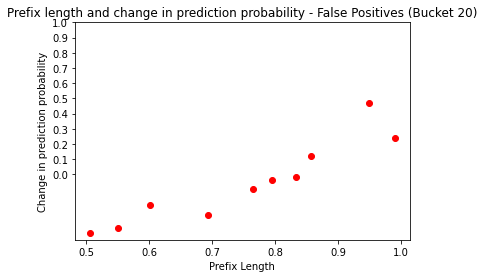

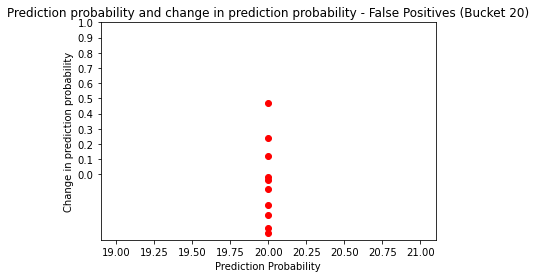

Bucket 21
Generating distributions for bucket
1 of 170 features
2 of 170 features
3 of 170 features
4 of 170 features
5 of 170 features
6 of 170 features
7 of 170 features
8 of 170 features
9 of 170 features
10 of 170 features
11 of 170 features
12 of 170 features
13 of 170 features
14 of 170 features
15 of 170 features
16 of 170 features
17 of 170 features
18 of 170 features
19 of 170 features
20 of 170 features
21 of 170 features
22 of 170 features
23 of 170 features
24 of 170 features
25 of 170 features
26 of 170 features
27 of 170 features
28 of 170 features
29 of 170 features
30 of 170 features
31 of 170 features
32 of 170 features
33 of 170 features
34 of 170 features
35 of 170 features
36 of 170 features
37 of 170 features
38 of 170 features
39 of 170 features
40 of 170 features
41 of 170 features
42 of 170 features
43 of 170 features
44 of 170 features
45 of 170 features
46 of 170 features
47 of 170 features
48 of 170 features
49 of 170 features
50 of 170 features
51 of 170 fea

Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - 

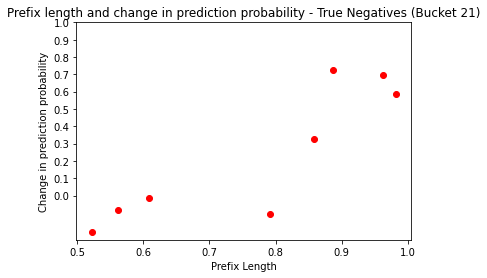

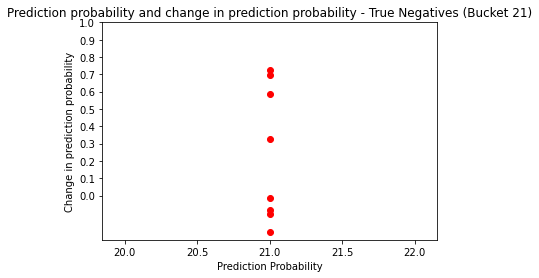

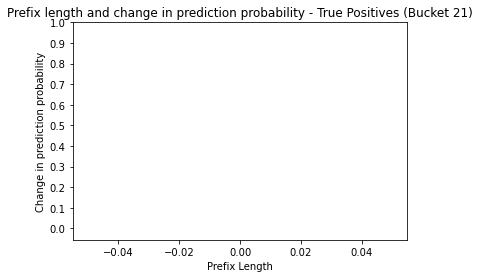

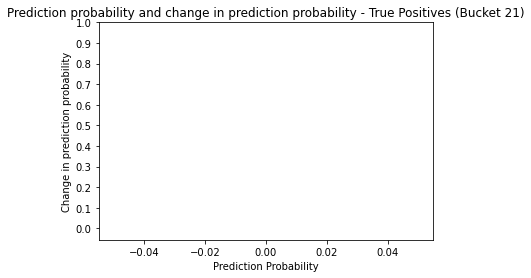

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 o

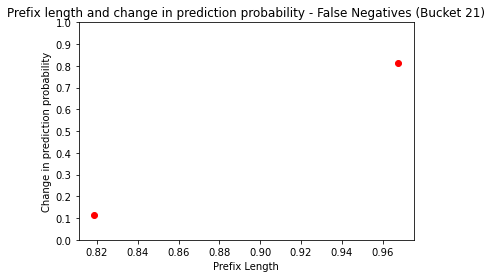

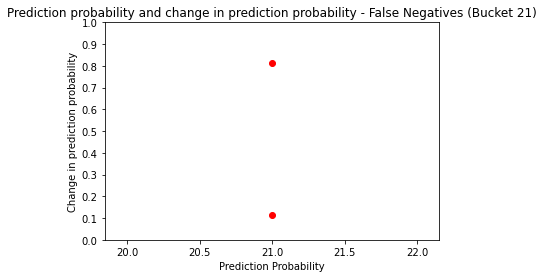

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 

Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating d

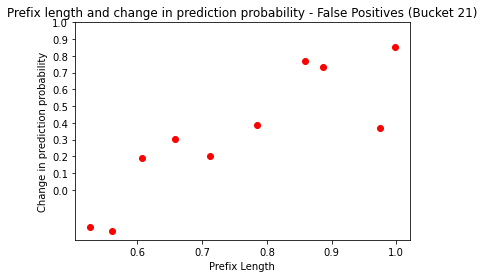

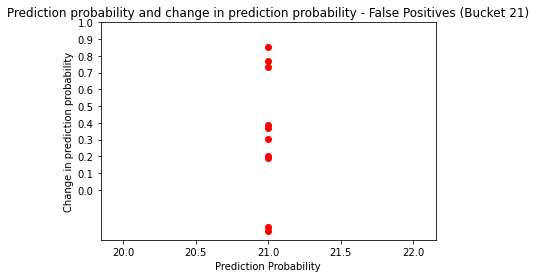

Bucket 22
Generating distributions for bucket
1 of 159 features
2 of 159 features
3 of 159 features
4 of 159 features
5 of 159 features
6 of 159 features
7 of 159 features
8 of 159 features
9 of 159 features
10 of 159 features
11 of 159 features
12 of 159 features
13 of 159 features
14 of 159 features
15 of 159 features
16 of 159 features
17 of 159 features
18 of 159 features
19 of 159 features
20 of 159 features
21 of 159 features
22 of 159 features
23 of 159 features
24 of 159 features
25 of 159 features
26 of 159 features
27 of 159 features
28 of 159 features
29 of 159 features
30 of 159 features
31 of 159 features
32 of 159 features
33 of 159 features
34 of 159 features
35 of 159 features
36 of 159 features
37 of 159 features
38 of 159 features
39 of 159 features
40 of 159 features
41 of 159 features
42 of 159 features
43 of 159 features
44 of 159 features
45 of 159 features
46 of 159 features
47 of 159 features
48 of 159 features
49 of 159 features
50 of 159 features
51 of 159 fea

Pertubing - Run 10
Category 1 of 4. Instance 7 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 8 of 9
Cre

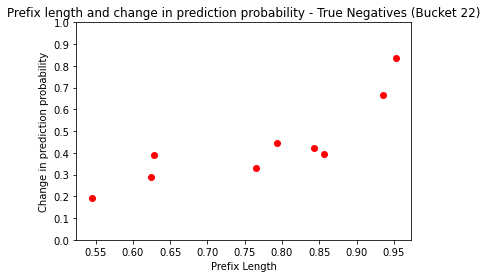

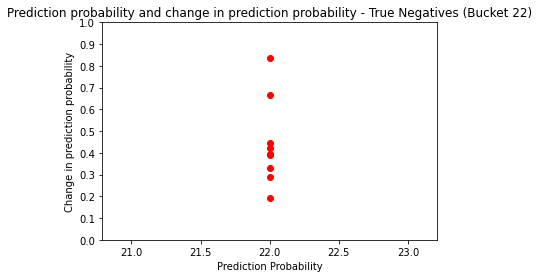

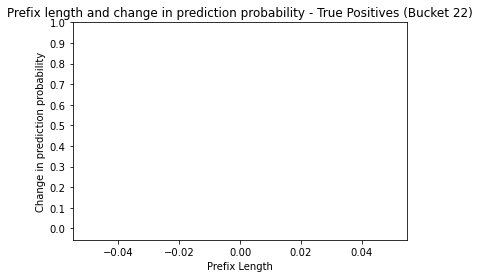

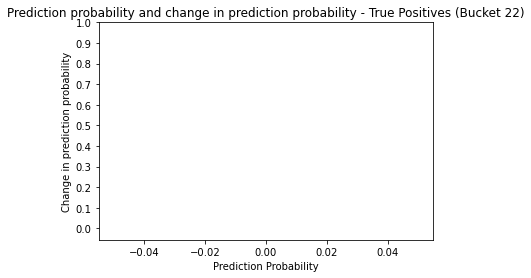

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 2
Creating explanations


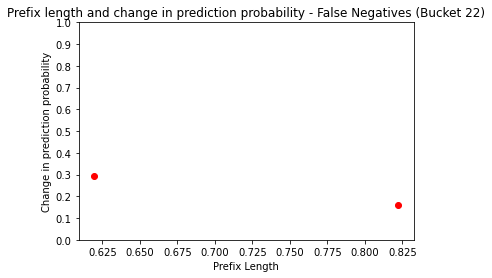

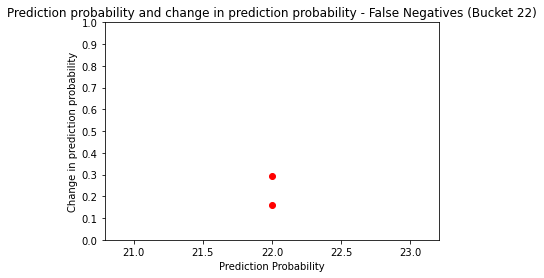

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating explanations


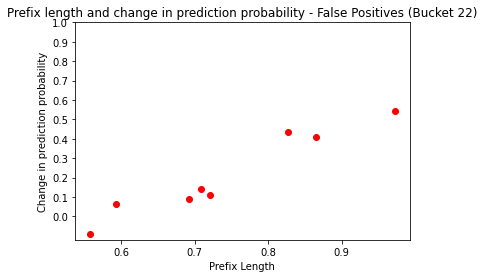

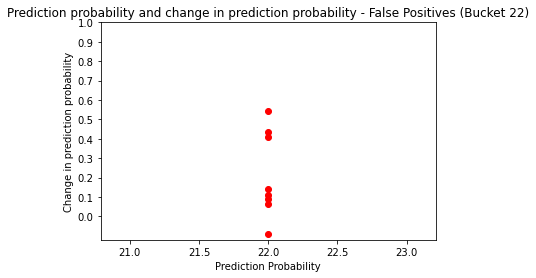

Bucket 23
Generating distributions for bucket
1 of 167 features
2 of 167 features
3 of 167 features
4 of 167 features
5 of 167 features
6 of 167 features
7 of 167 features
8 of 167 features
9 of 167 features
10 of 167 features
11 of 167 features
12 of 167 features
13 of 167 features
14 of 167 features
15 of 167 features
16 of 167 features
17 of 167 features
18 of 167 features
19 of 167 features
20 of 167 features
21 of 167 features
22 of 167 features
23 of 167 features
24 of 167 features
25 of 167 features
26 of 167 features
27 of 167 features
28 of 167 features
29 of 167 features
30 of 167 features
31 of 167 features
32 of 167 features
33 of 167 features
34 of 167 features
35 of 167 features
36 of 167 features
37 of 167 features
38 of 167 features
39 of 167 features
40 of 167 features
41 of 167 features
42 of 167 features
43 of 167 features
44 of 167 features
45 of 167 features
46 of 167 features
47 of 167 features
48 of 167 features
49 of 167 features
50 of 167 features
51 of 167 fea

Pertubing - Run 10
Category 1 of 4. Instance 6 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - 

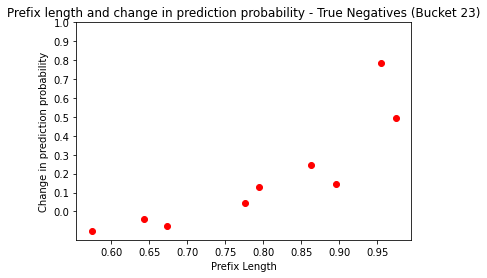

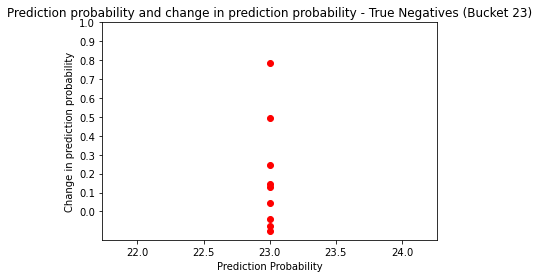

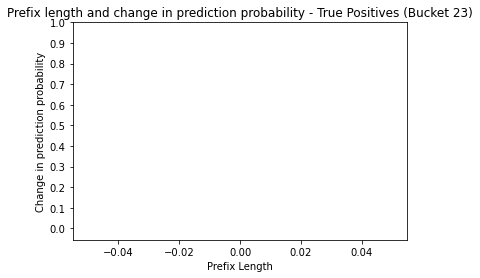

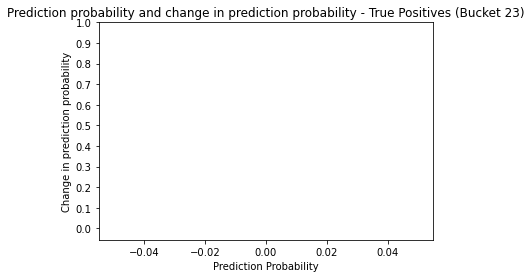

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 o

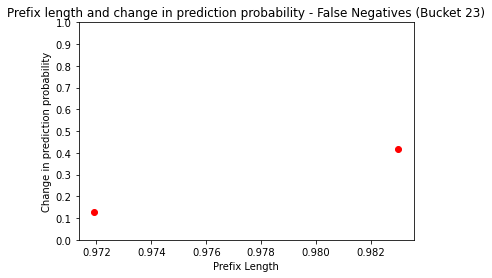

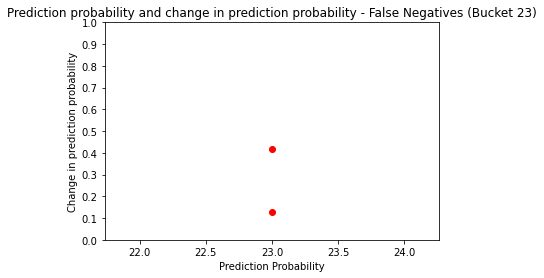

Category 4 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 o

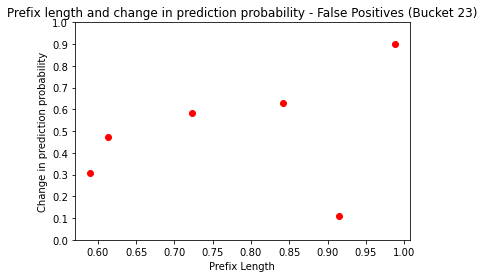

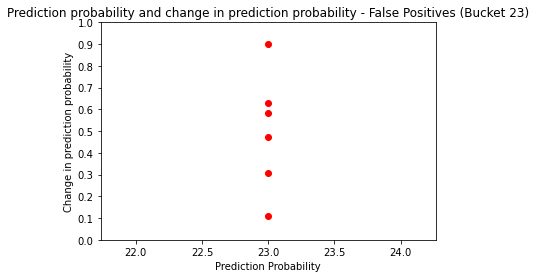

Bucket 24
Generating distributions for bucket
1 of 159 features
2 of 159 features
3 of 159 features
4 of 159 features
5 of 159 features
6 of 159 features
7 of 159 features
8 of 159 features
9 of 159 features
10 of 159 features
11 of 159 features
12 of 159 features
13 of 159 features
14 of 159 features
15 of 159 features
16 of 159 features
17 of 159 features
18 of 159 features
19 of 159 features
20 of 159 features
21 of 159 features
22 of 159 features
23 of 159 features
24 of 159 features
25 of 159 features
26 of 159 features
27 of 159 features
28 of 159 features
29 of 159 features
30 of 159 features
31 of 159 features
32 of 159 features
33 of 159 features
34 of 159 features
35 of 159 features
36 of 159 features
37 of 159 features
38 of 159 features
39 of 159 features
40 of 159 features
41 of 159 features
42 of 159 features
43 of 159 features
44 of 159 features
45 of 159 features
46 of 159 features
47 of 159 features
48 of 159 features
49 of 159 features
50 of 159 features
51 of 159 fea

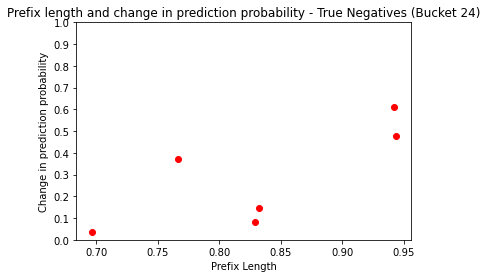

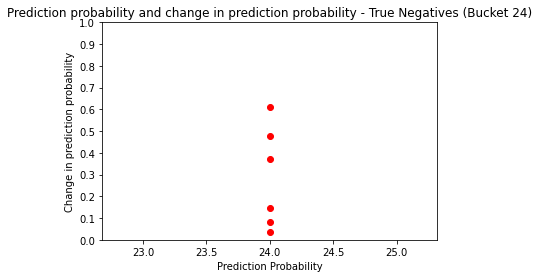

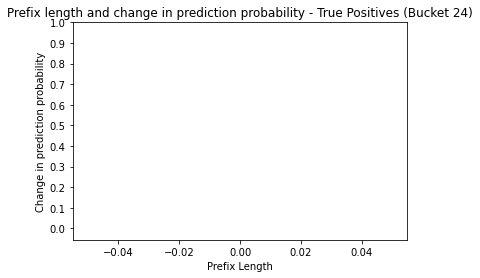

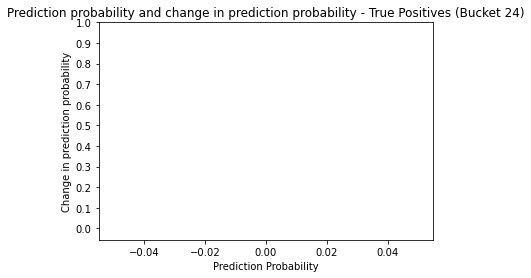

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 2
Creating explanations


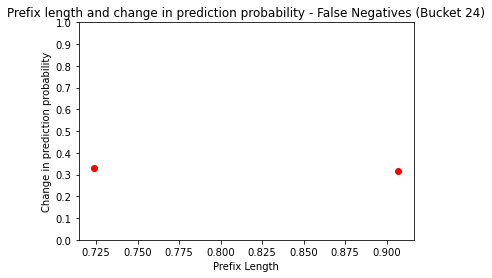

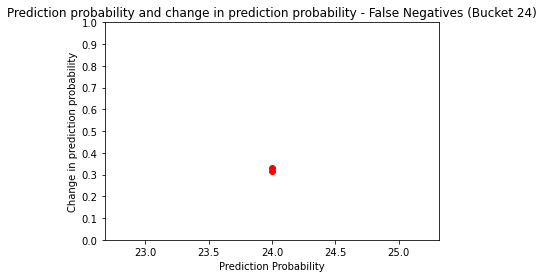

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 7
Creating explanations


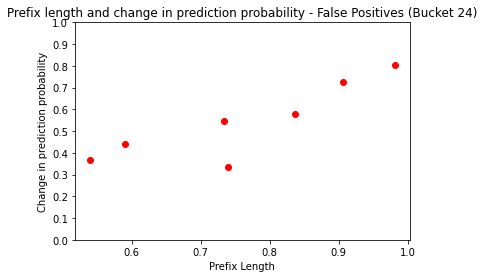

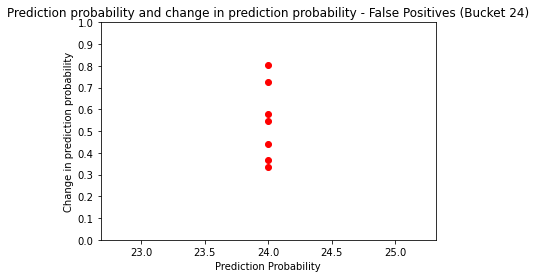

Bucket 25
Generating distributions for bucket
1 of 153 features
2 of 153 features
3 of 153 features
4 of 153 features
5 of 153 features
6 of 153 features
7 of 153 features
8 of 153 features
9 of 153 features
10 of 153 features
11 of 153 features
12 of 153 features
13 of 153 features
14 of 153 features
15 of 153 features
16 of 153 features
17 of 153 features
18 of 153 features
19 of 153 features
20 of 153 features
21 of 153 features
22 of 153 features
23 of 153 features
24 of 153 features
25 of 153 features
26 of 153 features
27 of 153 features
28 of 153 features
29 of 153 features
30 of 153 features
31 of 153 features
32 of 153 features
33 of 153 features
34 of 153 features
35 of 153 features
36 of 153 features
37 of 153 features
38 of 153 features
39 of 153 features
40 of 153 features
41 of 153 features
42 of 153 features
43 of 153 features
44 of 153 features
45 of 153 features
46 of 153 features
47 of 153 features
48 of 153 features
49 of 153 features
50 of 153 features
51 of 153 fea

Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


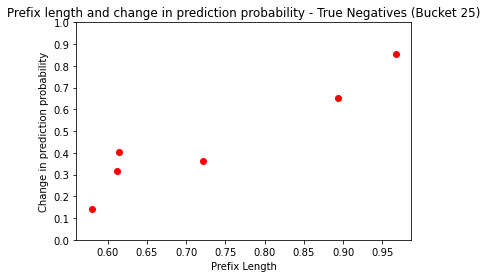

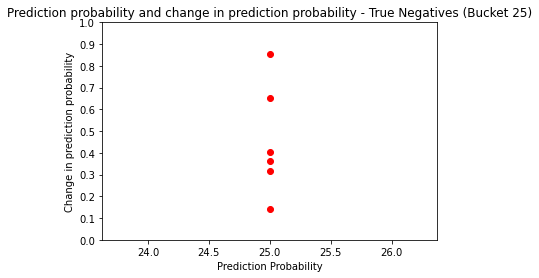

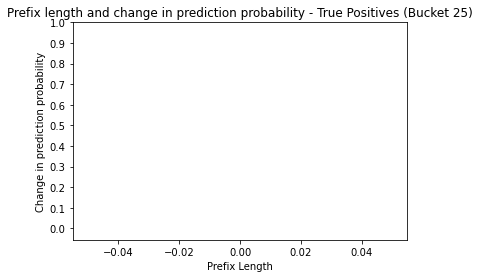

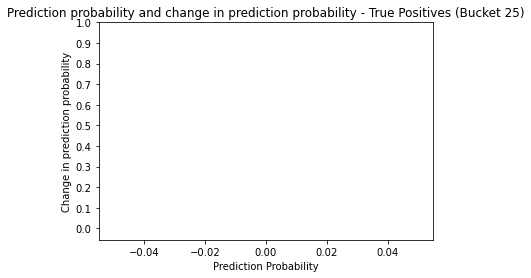

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 2
Creating explanations
Identifying relevant features
Creating dist

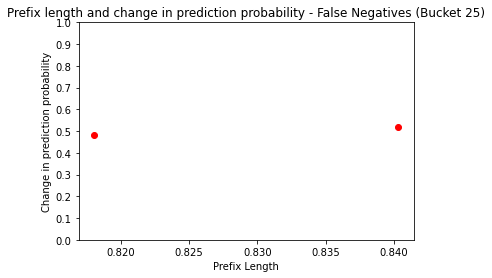

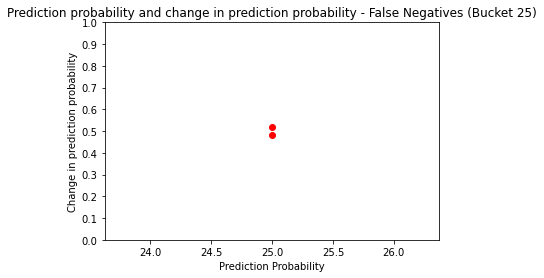

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 7
Creating explanations
Identifying relevant features
Creating dist

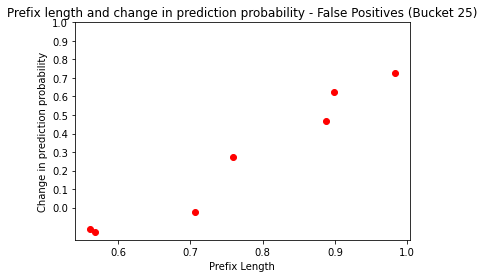

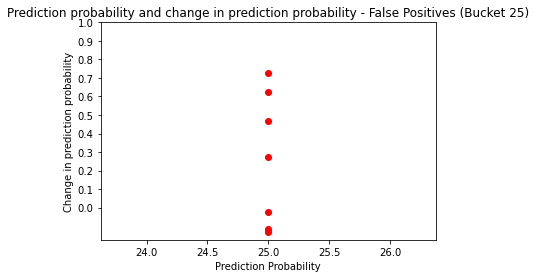

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val
                            if interval == 0:
                                interval = 1

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

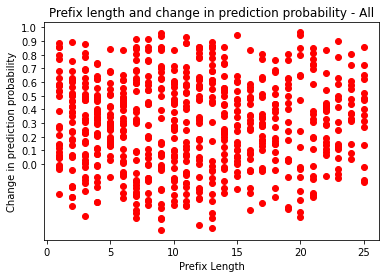

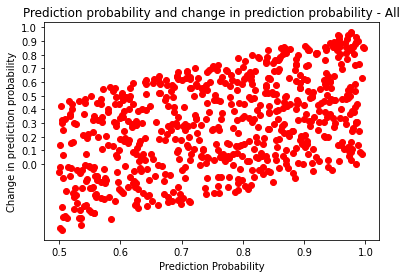

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

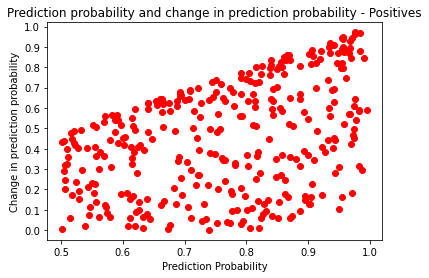

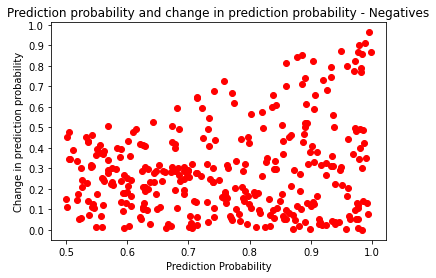

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

In [13]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

NameError: name 'all_lime_changes' is not defined

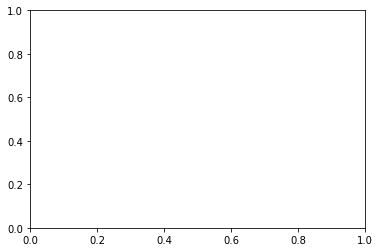

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [ ]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

In [ ]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))